# Cart Pole - V1


In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

env = gym.make('MountainCar-v0')

In [ ]:
class Tiling:
  def __init__(self, env, numTilings=8, numTiles=10):
    self.numTilings = numTilings
    self.numTiles = numTiles

    state, _ = env.reset()

    # Define limits
    cart_position_limit = 4.8
    pole_angle_limit = (24 * np.pi) / 180  # 24 degrees in radians
    cart_velocity_limit = 10
    pole_angular_velocity_limit = np.pi  # 3.1416 rad/s

    # Define low, high limits
    self.low = np.array([-cart_position_limit, -cart_velocity_limit, -pole_angle_limit, -pole_angular_velocity_limit])
    self.high = np.array([cart_position_limit, cart_velocity_limit, pole_angle_limit, pole_angular_velocity_limit])

    # Define offsets for tilings
    self.offsets = [
        (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
        for low, high in zip(self.low, self.high)
    ]

    # Create tilings
    self.tilings = self.createTilings()

  def getTilings(self):
    return self.tilings

  def createTilingGrid(self, low, high, bins, offsets):
    """ Create a single tiling grid """
    return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

  def createTilings(self):
    """ Create multiple tiling grids with offsets """
    tilings = []
    for i in range(self.numTilings):
        offsets_i = [offset[i] for offset in self.offsets]  # Pick correct offset for each tiling
        tilings.append(self.createTilingGrid(self.low, self.high, self.numTiles, offsets_i))
    return tilings

  def discretize(self, state):
    """ Convert continuous state into discrete indices across all tilings """
    discretized_indices = []
    for tiling in self.tilings:
        tile_indices = []
        for dim, bins in enumerate(tiling):
            tile_indices.append(np.digitize(state[dim], bins))  # Assign bin index for each dimension
        discretized_indices.append(tuple(tile_indices))
    return discretized_indices

In [ ]:
class sarsaAgent:
  def __init__(self,env,alpha=0.1,gamma=0.99,epsilon_start=1.0,epsilon_decay=0.995,epsilon_min=0.0001,numTilings=2,numTiles=5):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon_start
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = epsilon_min
    self.numTilings = numTilings
    self.numTiles = numTiles

    self.tiling = Tiling(env,numTilings,numTiles)
    self.numActions = self.env.action_space.n

    # Define feature representation using tile coding
    self.numFeatures = self.numTilings * self.numTiles** 4
    self.weights = np.zeros((self.numActions, self.numFeatures))  # Weights for each action

  def featureVector(self, state, action):
    """ Convert a continuous state into a binary feature vector. """
    discretized_indices = self.tiling.discretize(state)
    featureVector = np.zeros(self.numTilings * self.numTiles**4)

    for i, ds in enumerate(discretized_indices):
        index = sum(ds[d] * (self.numTiles**d) for d in range(len(ds)))  # Multi-dim index
        feature_index = i * self.numTiles**4 + index
        featureVector[feature_index] = 1  # Activate feature

    return featureVector

  def getQvalues(self,state,action):
    """ Approximates Q(s, a) = θ^T * φ(s, a) """
    featureVector = self.featureVector(state,action)
    return np.dot(self.weights[action], featureVector)

  def choose_epsilonGreedy_action(self,state):
    """ Chooses an action using ε-greedy policy. """
    if np.random.rand() < self.epsilon:
        return self.env.action_space.sample()  # Random action
    else:
        q_values = [self.getQvalues(state, a) for a in range(self.numActions)]
        return np.argmax(q_values)  # Best action

  def update(self,state,action,reward,next_state,next_action):
    """ SARSA update rule with linear function approximation """
    phi = self.featureVector(state, action)
    q_sa = self.getQvalues(state, action)
    q_next = self.getQvalues(next_state, next_action)

    td_target = reward + self.gamma * q_next
    td_error = td_target - q_sa
    self.weights[action] += (self.alpha/self.numTilings) * td_error * phi

  def train(self,num_episodes):
    episode_rewards = np.zeros(num_episodes)
    steps_to_completion = np.zeros(num_episodes)

    for i in tqdm(range(num_episodes)):

      totalReward = 0
      steps = 0

      state,_ = self.env.reset() #resetting the environment
      action = self.choose_epsilonGreedy_action(state)
      done = False

      while not done:
        next_state,reward,terminated,truncated,info = self.env.step(action)
        next_action = self.choose_epsilonGreedy_action(next_state)

        # Update weights using SARSA
        self.update(state, action, reward, next_state, next_action)

        state = next_state
        action = next_action

        totalReward += reward
        steps+=1

        done = terminated or truncated


      episode_rewards[i] = totalReward
      steps_to_completion[i] = steps

      #epsilon decay
      self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)
      if i % 50 == 0:
        avg_reward = np.mean(episode_rewards[max(0, i-50):i+1])
        print(f"Episode {i}/{num_episodes}, Avg Reward (Last 50): {avg_reward:.2f}, Epsilon: {self.epsilon:.4f}")

    return episode_rewards,steps_to_completion


In [ ]:
# Example usage
env = gym.make("CartPole-v1")
agent = sarsaAgent(env)
agent.train(num_episodes=2000)

  1%|          | 14/2000 [00:00<00:15, 132.11it/s]

Episode 0/2000, Avg Reward (Last 50): 18.00, Epsilon: 0.9950


  4%|▎         | 71/2000 [00:00<00:16, 113.68it/s]

Episode 50/2000, Avg Reward (Last 50): 29.80, Epsilon: 0.7744


  6%|▌         | 112/2000 [00:01<00:27, 69.62it/s]

Episode 100/2000, Avg Reward (Last 50): 48.18, Epsilon: 0.6027


  8%|▊         | 155/2000 [00:02<00:45, 40.98it/s]

Episode 150/2000, Avg Reward (Last 50): 72.59, Epsilon: 0.4691


 10%|█         | 207/2000 [00:04<01:04, 27.66it/s]

Episode 200/2000, Avg Reward (Last 50): 110.69, Epsilon: 0.3651


 13%|█▎        | 253/2000 [00:06<01:16, 22.93it/s]

Episode 250/2000, Avg Reward (Last 50): 131.08, Epsilon: 0.2842


 15%|█▌        | 302/2000 [00:08<02:21, 11.98it/s]

Episode 300/2000, Avg Reward (Last 50): 160.25, Epsilon: 0.2212


 18%|█▊        | 353/2000 [00:12<01:00, 27.31it/s]

Episode 350/2000, Avg Reward (Last 50): 158.45, Epsilon: 0.1721


 20%|██        | 403/2000 [00:15<01:42, 15.53it/s]

Episode 400/2000, Avg Reward (Last 50): 206.06, Epsilon: 0.1340


 23%|██▎       | 453/2000 [00:19<02:07, 12.15it/s]

Episode 450/2000, Avg Reward (Last 50): 217.10, Epsilon: 0.1043


 25%|██▌       | 503/2000 [00:24<03:03,  8.17it/s]

Episode 500/2000, Avg Reward (Last 50): 253.02, Epsilon: 0.0812


 28%|██▊       | 552/2000 [00:29<02:25,  9.94it/s]

Episode 550/2000, Avg Reward (Last 50): 289.16, Epsilon: 0.0632


 30%|███       | 602/2000 [00:33<02:20,  9.97it/s]

Episode 600/2000, Avg Reward (Last 50): 247.45, Epsilon: 0.0492


 33%|███▎      | 653/2000 [00:39<02:20,  9.57it/s]

Episode 650/2000, Avg Reward (Last 50): 305.67, Epsilon: 0.0383


 35%|███▌      | 702/2000 [00:43<02:31,  8.56it/s]

Episode 700/2000, Avg Reward (Last 50): 229.57, Epsilon: 0.0298


 38%|███▊      | 752/2000 [00:50<02:39,  7.83it/s]

Episode 750/2000, Avg Reward (Last 50): 308.84, Epsilon: 0.0232


 40%|████      | 802/2000 [00:55<02:40,  7.45it/s]

Episode 800/2000, Avg Reward (Last 50): 336.98, Epsilon: 0.0180


 43%|████▎     | 852/2000 [01:04<02:58,  6.45it/s]

Episode 850/2000, Avg Reward (Last 50): 398.02, Epsilon: 0.0140


 45%|████▌     | 902/2000 [01:11<02:45,  6.62it/s]

Episode 900/2000, Avg Reward (Last 50): 393.31, Epsilon: 0.0109


 48%|████▊     | 952/2000 [01:19<02:56,  5.93it/s]

Episode 950/2000, Avg Reward (Last 50): 429.69, Epsilon: 0.0085


 50%|█████     | 1001/2000 [01:27<01:56,  8.55it/s]

Episode 1000/2000, Avg Reward (Last 50): 420.08, Epsilon: 0.0066


 53%|█████▎    | 1052/2000 [01:33<01:50,  8.58it/s]

Episode 1050/2000, Avg Reward (Last 50): 330.67, Epsilon: 0.0052


 55%|█████▌    | 1101/2000 [01:38<01:27, 10.31it/s]

Episode 1100/2000, Avg Reward (Last 50): 240.90, Epsilon: 0.0040


 58%|█████▊    | 1152/2000 [01:44<02:04,  6.79it/s]

Episode 1150/2000, Avg Reward (Last 50): 318.96, Epsilon: 0.0031


 60%|██████    | 1201/2000 [01:52<02:21,  5.63it/s]

Episode 1200/2000, Avg Reward (Last 50): 419.39, Epsilon: 0.0024


 63%|██████▎   | 1253/2000 [01:59<01:36,  7.72it/s]

Episode 1250/2000, Avg Reward (Last 50): 415.27, Epsilon: 0.0019


 65%|██████▌   | 1302/2000 [02:08<01:42,  6.82it/s]

Episode 1300/2000, Avg Reward (Last 50): 446.00, Epsilon: 0.0015


 68%|██████▊   | 1352/2000 [02:15<01:19,  8.13it/s]

Episode 1350/2000, Avg Reward (Last 50): 413.96, Epsilon: 0.0011


 70%|███████   | 1402/2000 [02:23<01:14,  8.06it/s]

Episode 1400/2000, Avg Reward (Last 50): 376.55, Epsilon: 0.0009


 73%|███████▎  | 1452/2000 [02:32<01:42,  5.36it/s]

Episode 1450/2000, Avg Reward (Last 50): 426.65, Epsilon: 0.0007


 75%|███████▌  | 1502/2000 [02:40<01:26,  5.79it/s]

Episode 1500/2000, Avg Reward (Last 50): 479.96, Epsilon: 0.0005


 78%|███████▊  | 1551/2000 [02:49<00:50,  8.95it/s]

Episode 1550/2000, Avg Reward (Last 50): 437.82, Epsilon: 0.0004


 80%|████████  | 1601/2000 [02:56<01:26,  4.62it/s]

Episode 1600/2000, Avg Reward (Last 50): 368.10, Epsilon: 0.0003


 83%|████████▎ | 1652/2000 [03:04<00:43,  7.98it/s]

Episode 1650/2000, Avg Reward (Last 50): 435.31, Epsilon: 0.0003


 85%|████████▌ | 1702/2000 [03:12<00:37,  8.02it/s]

Episode 1700/2000, Avg Reward (Last 50): 429.71, Epsilon: 0.0002


 88%|████████▊ | 1751/2000 [03:19<00:30,  8.13it/s]

Episode 1750/2000, Avg Reward (Last 50): 378.37, Epsilon: 0.0002


 90%|█████████ | 1802/2000 [03:28<00:31,  6.24it/s]

Episode 1800/2000, Avg Reward (Last 50): 426.33, Epsilon: 0.0001


 93%|█████████▎| 1852/2000 [03:36<00:22,  6.70it/s]

Episode 1850/2000, Avg Reward (Last 50): 415.14, Epsilon: 0.0001


 95%|█████████▌| 1903/2000 [03:43<00:06, 15.39it/s]

Episode 1900/2000, Avg Reward (Last 50): 408.12, Epsilon: 0.0001


 98%|█████████▊| 1952/2000 [03:51<00:07,  6.51it/s]

Episode 1950/2000, Avg Reward (Last 50): 369.22, Epsilon: 0.0001


100%|██████████| 2000/2000 [03:59<00:00,  8.36it/s]


(array([ 18.,  21.,  18., ..., 500., 500., 500.]),
 array([ 18.,  21.,  18., ..., 500., 500., 500.]))

In [ ]:
class QLearningAgent:
  def __init__(self, env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05,numTilings=8, numTiles=10):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.tau = tau_start
    self.tau_decay = tau_decay
    self.tau_min = tau_min

    self.numTilings = numTilings
    self.numTiles = numTiles

    self.tiling = Tiling(env, numTilings, numTiles)
    self.numActions = self.env.action_space.n

    # Feature vector size: numTilings * numTiles * number_of_state_variables
    self.numFeatures = self.numTilings * self.numTiles ** self.env.observation_space.shape[0]
    # Weight vector for each action.
    self.weights = np.zeros((self.numActions, self.numFeatures))

  def featureVector(self, state, action):
    """ Convert a continuous state into a binary feature vector. """
    discretized_indices = self.tiling.discretize(state)
    featureVector = np.zeros(self.numTilings * self.numTiles**4)

    for i, ds in enumerate(discretized_indices):
        index = sum(ds[d] * (self.numTiles**d) for d in range(len(ds)))  # Multi-dim index
        feature_index = i * self.numTiles**4 + index
        featureVector[feature_index] = 1  # Activate feature

    return featureVector

  def getQvalue(self, state, action):
    """ Compute Q(s, a) = θ^T * φ(s, a). """
    phi = self.featureVector(state, action)
    return np.dot(self.weights[action], phi)

  def choose_action_softmax(self, state):
    """ Choose an action using a softmax (Boltzmann) policy. """
    q_values = np.array([self.getQvalue(state, a) for a in range(self.numActions)])
    # For numerical stability, subtract the maximum Q-value.
    exp_values = np.exp((q_values - np.max(q_values)) / self.tau)
    probs = exp_values / np.sum(exp_values)
    return np.random.choice(self.numActions, p=probs)

  def update(self, state, action, reward, next_state):
    """ Q-learning update rule with linear function approximation. """
    phi = self.featureVector(state, action)
    q_sa = self.getQvalue(state, action)
    # For Q-learning, we use the maximum Q-value over next actions.
    q_next_max = max([self.getQvalue(next_state, a) for a in range(self.numActions)])
    td_target = reward + self.gamma * q_next_max
    td_error = td_target - q_sa
    self.weights[action] += (self.alpha/self.numTilings) * td_error * phi

  def train(self, num_episodes):
    episode_rewards = np.zeros(num_episodes)
    steps_to_completion = np.zeros(num_episodes)

    for i in tqdm(range(num_episodes)):
      totalReward = 0
      steps = 0
      state, _ = self.env.reset()
      done = False

      while not done:
          action = self.choose_action_softmax(state)
          next_state, reward, terminated, truncated, _ = self.env.step(action)
          done = terminated or truncated

          self.update(state, action, reward, next_state)

          state = next_state
          totalReward += reward
          steps += 1

      episode_rewards[i] = totalReward
      steps_to_completion[i] = steps

      # Decay the temperature
      self.tau = max(self.tau_min, self.tau * self.tau_decay)
      if i % 50 == 0:
        avg_reward = np.mean(episode_rewards[max(0, i-50):i+1])
        print(f"Episode {i}/{num_episodes}, Avg Reward (Last 50): {avg_reward:.2f}, Tau: {self.tau:.4f}")

    return episode_rewards, steps_to_completion

In [ ]:
env = gym.make("CartPole-v1")
agent = QLearningAgent(env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.999, tau_min=0.05, numTilings=8, numTiles=5)
rewards, steps = agent.train(num_episodes=2000)

  0%|          | 4/2000 [00:00<01:05, 30.33it/s]

Episode 0/2000, Avg Reward (Last 50): 13.00, Tau: 0.9990


  3%|▎         | 55/2000 [00:02<01:33, 20.79it/s]

Episode 50/2000, Avg Reward (Last 50): 33.90, Tau: 0.9503


  5%|▌         | 103/2000 [00:05<01:58, 16.03it/s]

Episode 100/2000, Avg Reward (Last 50): 43.61, Tau: 0.9039


  8%|▊         | 152/2000 [00:08<02:58, 10.36it/s]

Episode 150/2000, Avg Reward (Last 50): 51.80, Tau: 0.8598


 10%|█         | 203/2000 [00:13<02:17, 13.11it/s]

Episode 200/2000, Avg Reward (Last 50): 60.63, Tau: 0.8178


 13%|█▎        | 252/2000 [00:19<05:14,  5.55it/s]

Episode 250/2000, Avg Reward (Last 50): 100.53, Tau: 0.7779


 15%|█▌        | 301/2000 [00:30<06:04,  4.67it/s]

Episode 300/2000, Avg Reward (Last 50): 161.90, Tau: 0.7400


 18%|█▊        | 351/2000 [00:43<06:40,  4.12it/s]

Episode 350/2000, Avg Reward (Last 50): 177.53, Tau: 0.7039


 20%|██        | 402/2000 [00:56<06:20,  4.20it/s]

Episode 400/2000, Avg Reward (Last 50): 201.14, Tau: 0.6695


 23%|██▎       | 451/2000 [01:13<12:13,  2.11it/s]

Episode 450/2000, Avg Reward (Last 50): 234.37, Tau: 0.6368


 25%|██▌       | 501/2000 [01:34<11:31,  2.17it/s]

Episode 500/2000, Avg Reward (Last 50): 321.90, Tau: 0.6058


 28%|██▊       | 551/2000 [01:57<11:30,  2.10it/s]

Episode 550/2000, Avg Reward (Last 50): 338.02, Tau: 0.5762


 30%|███       | 601/2000 [02:21<10:48,  2.16it/s]

Episode 600/2000, Avg Reward (Last 50): 354.67, Tau: 0.5481


 33%|███▎      | 651/2000 [02:45<10:40,  2.11it/s]

Episode 650/2000, Avg Reward (Last 50): 346.90, Tau: 0.5214


 35%|███▌      | 701/2000 [03:09<11:36,  1.87it/s]

Episode 700/2000, Avg Reward (Last 50): 360.08, Tau: 0.4959


 38%|███▊      | 751/2000 [03:34<11:33,  1.80it/s]

Episode 750/2000, Avg Reward (Last 50): 363.25, Tau: 0.4717


 40%|████      | 801/2000 [03:56<11:38,  1.72it/s]

Episode 800/2000, Avg Reward (Last 50): 330.67, Tau: 0.4487


 43%|████▎     | 851/2000 [04:20<09:18,  2.06it/s]

Episode 850/2000, Avg Reward (Last 50): 357.29, Tau: 0.4268


 45%|████▌     | 901/2000 [04:42<07:04,  2.59it/s]

Episode 900/2000, Avg Reward (Last 50): 322.59, Tau: 0.4060


 48%|████▊     | 951/2000 [05:03<06:53,  2.54it/s]

Episode 950/2000, Avg Reward (Last 50): 312.31, Tau: 0.3862


 50%|█████     | 1001/2000 [05:29<07:18,  2.28it/s]

Episode 1000/2000, Avg Reward (Last 50): 373.41, Tau: 0.3673


 53%|█████▎    | 1051/2000 [05:52<06:41,  2.36it/s]

Episode 1050/2000, Avg Reward (Last 50): 349.37, Tau: 0.3494


 55%|█████▌    | 1101/2000 [06:16<08:35,  1.74it/s]

Episode 1100/2000, Avg Reward (Last 50): 345.24, Tau: 0.3324


 58%|█████▊    | 1151/2000 [06:39<07:17,  1.94it/s]

Episode 1150/2000, Avg Reward (Last 50): 348.65, Tau: 0.3161


 60%|██████    | 1201/2000 [07:03<06:53,  1.93it/s]

Episode 1200/2000, Avg Reward (Last 50): 353.41, Tau: 0.3007


 63%|██████▎   | 1251/2000 [07:25<05:07,  2.44it/s]

Episode 1250/2000, Avg Reward (Last 50): 319.00, Tau: 0.2860


 65%|██████▌   | 1301/2000 [07:47<05:03,  2.31it/s]

Episode 1300/2000, Avg Reward (Last 50): 320.06, Tau: 0.2721


 68%|██████▊   | 1351/2000 [08:11<05:11,  2.08it/s]

Episode 1350/2000, Avg Reward (Last 50): 355.39, Tau: 0.2588


 70%|███████   | 1401/2000 [08:34<05:51,  1.71it/s]

Episode 1400/2000, Avg Reward (Last 50): 340.76, Tau: 0.2462


 73%|███████▎  | 1451/2000 [08:56<03:39,  2.50it/s]

Episode 1450/2000, Avg Reward (Last 50): 324.29, Tau: 0.2342


 75%|███████▌  | 1501/2000 [09:19<03:11,  2.61it/s]

Episode 1500/2000, Avg Reward (Last 50): 333.94, Tau: 0.2227


 78%|███████▊  | 1551/2000 [09:40<02:57,  2.53it/s]

Episode 1550/2000, Avg Reward (Last 50): 300.73, Tau: 0.2119


 80%|████████  | 1601/2000 [10:01<04:35,  1.45it/s]

Episode 1600/2000, Avg Reward (Last 50): 319.49, Tau: 0.2015


 83%|████████▎ | 1651/2000 [10:24<02:21,  2.47it/s]

Episode 1650/2000, Avg Reward (Last 50): 349.08, Tau: 0.1917


 85%|████████▌ | 1701/2000 [10:46<01:58,  2.51it/s]

Episode 1700/2000, Avg Reward (Last 50): 311.86, Tau: 0.1823


 88%|████████▊ | 1751/2000 [11:07<01:38,  2.52it/s]

Episode 1750/2000, Avg Reward (Last 50): 302.82, Tau: 0.1734


 90%|█████████ | 1801/2000 [11:27<01:22,  2.40it/s]

Episode 1800/2000, Avg Reward (Last 50): 316.00, Tau: 0.1650


 93%|█████████▎| 1851/2000 [11:50<01:14,  2.00it/s]

Episode 1850/2000, Avg Reward (Last 50): 319.76, Tau: 0.1569


 95%|█████████▌| 1901/2000 [12:12<00:44,  2.22it/s]

Episode 1900/2000, Avg Reward (Last 50): 326.16, Tau: 0.1493


 98%|█████████▊| 1951/2000 [12:36<00:22,  2.23it/s]

Episode 1950/2000, Avg Reward (Last 50): 346.16, Tau: 0.1420


100%|██████████| 2000/2000 [12:56<00:00,  2.57it/s]


# Mountain car

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Tiling:
    def __init__(self, env, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles

        # Define MountainCar state limits
        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07

        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])

        # Define offsets for tilings
        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]

        self.tilings = self.createTilings()

    def createTilingGrid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

    def createTilings(self):
        return [self.createTilingGrid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]

    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]

class sarsaAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.0001, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.numTilings = numTilings
        self.numTiles = numTiles

        self.tiling = Tiling(env, numTilings, numTiles)
        self.numActions = self.env.action_space.n

        self.numFeatures = self.numTilings * self.numTiles**2  # Only 2D state (position, velocity)
        self.weights = np.zeros((self.numActions, self.numFeatures))

    def featureVector(self, state, action):
        """ Convert a continuous state into a binary feature vector. """
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)

        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]  # 2D index
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1  # Activate feature

        return featureVector

    def getQvalues(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))

    def choose_epsilonGreedy_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        q_values = [self.getQvalues(state, a) for a in range(self.numActions)]
        return np.argmax(q_values)

    def update(self, state, action, reward, next_state, next_action):
        phi = self.featureVector(state, action)
        q_sa = self.getQvalues(state, action)
        q_next = self.getQvalues(next_state, next_action)

        td_target = reward + self.gamma * q_next
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

    def train(self, num_episodes):
        episode_rewards = np.zeros(num_episodes)
        steps_to_completion = np.zeros(num_episodes)

        for i in range(num_episodes):
            totalReward, steps = 0, 0
            state, _ = self.env.reset()
            action = self.choose_epsilonGreedy_action(state)
            done = False

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                next_action = self.choose_epsilonGreedy_action(next_state)

                self.update(state, action, reward, next_state, next_action)

                state, action = next_state, next_action
                totalReward += reward
                steps += 1
                done = terminated or truncated

            episode_rewards[i] = totalReward
            steps_to_completion[i] = steps

            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            if i % 100 == 0:
                avg_reward = np.mean(episode_rewards[max(0, i-100):i+1])
                print(f"Episode {i}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Epsilon: {self.epsilon:.4f}")

        return episode_rewards, steps_to_completion

# Initialize environment and agent for MountainCar-v0
env = gym.make("MountainCar-v0")
agent = sarsaAgent(alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.0001, numTilings=8, numTiles=10)

# Train the agent
rewards, steps = agent.train(5000)


Episode 0/5000, Avg Reward (Last 100): -200.00, Epsilon: 0.9950
Episode 100/5000, Avg Reward (Last 100): -200.00, Epsilon: 0.6027
Episode 200/5000, Avg Reward (Last 100): -199.73, Epsilon: 0.3651
Episode 300/5000, Avg Reward (Last 100): -196.72, Epsilon: 0.2212
Episode 400/5000, Avg Reward (Last 100): -189.07, Epsilon: 0.1340
Episode 500/5000, Avg Reward (Last 100): -173.24, Epsilon: 0.0812
Episode 600/5000, Avg Reward (Last 100): -162.98, Epsilon: 0.0492
Episode 700/5000, Avg Reward (Last 100): -155.02, Epsilon: 0.0298
Episode 800/5000, Avg Reward (Last 100): -148.74, Epsilon: 0.0180
Episode 900/5000, Avg Reward (Last 100): -143.95, Epsilon: 0.0109
Episode 1000/5000, Avg Reward (Last 100): -138.17, Epsilon: 0.0066
Episode 1100/5000, Avg Reward (Last 100): -129.80, Epsilon: 0.0040
Episode 1200/5000, Avg Reward (Last 100): -135.52, Epsilon: 0.0024
Episode 1300/5000, Avg Reward (Last 100): -136.93, Epsilon: 0.0015
Episode 1400/5000, Avg Reward (Last 100): -130.19, Epsilon: 0.0009
Episode

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Tiling:
    def __init__(self, env, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles

        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07
        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])

        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]

        self.tilings = self.createTilings()

    def createTilingGrid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

    def createTilings(self):
        return [self.createTilingGrid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]

    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.tau = tau_start
        self.tau_decay = tau_decay
        self.tau_min = tau_min

        self.numTilings = numTilings
        self.numTiles = numTiles

        self.tiling = Tiling(env, numTilings, numTiles)
        self.numActions = self.env.action_space.n

        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))

    def featureVector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)

        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1

        return featureVector

    def getQvalue(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))

    def choose_action_softmax(self, state):
        q_values = np.array([self.getQvalue(state, a) for a in range(self.numActions)])
        exp_values = np.exp((q_values - np.max(q_values)) / self.tau)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(self.numActions, p=probs)

    def update(self, state, action, reward, next_state):
        phi = self.featureVector(state, action)
        q_sa = self.getQvalue(state, action)
        q_next_max = max([self.getQvalue(next_state, a) for a in range(self.numActions)])
        td_target = reward + self.gamma * q_next_max
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

    def train(self, num_episodes):
        episode_rewards = np.zeros(num_episodes)
        steps_to_completion = np.zeros(num_episodes)
        running_avg=np.zeros(num_episodes)
        for i in range(num_episodes):
            totalReward, steps = 0, 0
            state, _ = self.env.reset()
            done = False

            while not done:
                action = self.choose_action_softmax(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                self.update(state, action, reward, next_state)

                state = next_state
                totalReward += reward
                steps += 1

            episode_rewards[i] = totalReward
            steps_to_completion[i] = steps
            running_avg[i]=np.mean(episode_rewards[max(0, i-100):i+1])
            self.tau = max(self.tau_min, self.tau * self.tau_decay)
            if i % 100 == 0:
                avg_reward = np.mean(episode_rewards[max(0, i-100):i+1])
                print(f"Episode {i}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Tau: {self.tau:.4f}")

        return episode_rewards, steps_to_completion,running_avg

# Initialize environment and agent for MountainCar-v0
env = gym.make("MountainCar-v0")
agent = QLearningAgent(env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05, numTilings=8, numTiles=10)

# Train the agent
rewards, steps,running_avg = agent.train(5000)


Episode 0/5000, Avg Reward (Last 100): -200.00, Tau: 0.9950
Episode 100/5000, Avg Reward (Last 100): -200.00, Tau: 0.6027
Episode 200/5000, Avg Reward (Last 100): -200.00, Tau: 0.3651
Episode 300/5000, Avg Reward (Last 100): -199.59, Tau: 0.2212
Episode 400/5000, Avg Reward (Last 100): -193.51, Tau: 0.1340
Episode 500/5000, Avg Reward (Last 100): -182.09, Tau: 0.0812
Episode 600/5000, Avg Reward (Last 100): -162.46, Tau: 0.0500
Episode 700/5000, Avg Reward (Last 100): -162.31, Tau: 0.0500
Episode 800/5000, Avg Reward (Last 100): -151.55, Tau: 0.0500
Episode 900/5000, Avg Reward (Last 100): -146.87, Tau: 0.0500
Episode 1000/5000, Avg Reward (Last 100): -137.23, Tau: 0.0500
Episode 1100/5000, Avg Reward (Last 100): -125.98, Tau: 0.0500
Episode 1200/5000, Avg Reward (Last 100): -125.00, Tau: 0.0500
Episode 1300/5000, Avg Reward (Last 100): -124.79, Tau: 0.0500
Episode 1400/5000, Avg Reward (Last 100): -124.00, Tau: 0.0500
Episode 1500/5000, Avg Reward (Last 100): -125.90, Tau: 0.0500
Epis

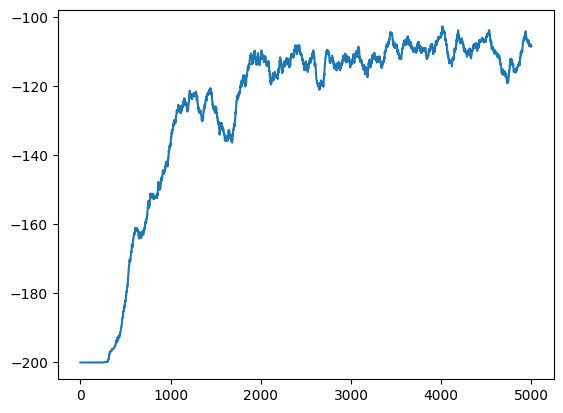

In [ ]:
import matplotlib.pyplot as plt
plt.plot(running_avg)

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Tiling:
    def __init__(self, env, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles

        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07
        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])

        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]

        self.tilings = self.createTilings()

    def createTilingGrid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

    def createTilings(self):
        return [self.createTilingGrid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]

    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.tau = tau_start
        self.tau_decay = tau_decay
        self.tau_min = tau_min

        self.numTilings = numTilings
        self.numTiles = numTiles

        self.tiling = Tiling(env, numTilings, numTiles)
        self.numActions = self.env.action_space.n

        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))

    def featureVector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)

        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1

        return featureVector

    def getQvalue(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))

    def choose_action_softmax(self, state):
        q_values = np.array([self.getQvalue(state, a) for a in range(self.numActions)])
        exp_values = np.exp((q_values - np.max(q_values)) / self.tau)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(self.numActions, p=probs)

    def update(self, state, action, reward, next_state):
        phi = self.featureVector(state, action)
        q_sa = self.getQvalue(state, action)
        q_next_max = max([self.getQvalue(next_state, a) for a in range(self.numActions)])
        td_target = reward + self.gamma * q_next_max
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

    def train(self, num_episodes, num_runs=5):
        episode_rewards = np.zeros((num_runs, num_episodes))
        steps_to_completion = np.zeros((num_runs, num_episodes))

        for run in range(num_runs):
            print(f"Run:{run+1}")
            self.weights = np.zeros((self.numActions, self.numFeatures))  # Reset weights for each run
            self.tau = 1.0  # Reset temperature for each run

            for i in range(num_episodes):
                totalReward, steps = 0, 0
                state, _ = self.env.reset()
                done = False

                while not done:
                    action = self.choose_action_softmax(state)
                    next_state, reward, terminated, truncated, _ = self.env.step(action)
                    done = terminated or truncated

                    self.update(state, action, reward, next_state)

                    state = next_state
                    totalReward += reward
                    steps += 1

                episode_rewards[run, i] = totalReward
                steps_to_completion[run, i] = steps

                self.tau = max(self.tau_min, self.tau * self.tau_decay)
                if i % 100 == 0:
                    avg_reward = np.mean(episode_rewards[run, max(0, i-100):i+1])
                    print(f"Episode {i}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Tau: {self.tau:.4f}")

        # Compute mean and standard deviation across runs
        mean_rewards = np.mean(episode_rewards, axis=0)
        std_rewards = np.std(episode_rewards, axis=0)
        mean_steps = np.mean(steps_to_completion, axis=0)
        std_steps = np.std(steps_to_completion, axis=0)

        return mean_rewards, std_rewards, mean_steps, std_steps

# Initialize environment and agent for MountainCar-v0
env = gym.make("MountainCar-v0")
agent = QLearningAgent(env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05, numTilings=8, numTiles=10)

# Train the agent over multiple runs
mean_rewards, std_rewards, mean_steps, std_steps = agent.train(5000, num_runs=5)

print("Training complete. Mean rewards and standard deviations computed.")


Run:1
Episode 0/5000, Avg Reward (Last 100): -200.00, Tau: 0.9950
Episode 100/5000, Avg Reward (Last 100): -200.00, Tau: 0.6027
Episode 200/5000, Avg Reward (Last 100): -200.00, Tau: 0.3651
Episode 300/5000, Avg Reward (Last 100): -199.45, Tau: 0.2212
Episode 400/5000, Avg Reward (Last 100): -190.15, Tau: 0.1340
Episode 500/5000, Avg Reward (Last 100): -178.28, Tau: 0.0812
Episode 600/5000, Avg Reward (Last 100): -167.96, Tau: 0.0500
Episode 700/5000, Avg Reward (Last 100): -162.65, Tau: 0.0500
Episode 800/5000, Avg Reward (Last 100): -155.96, Tau: 0.0500
Episode 900/5000, Avg Reward (Last 100): -145.13, Tau: 0.0500
Episode 1000/5000, Avg Reward (Last 100): -133.81, Tau: 0.0500
Episode 1100/5000, Avg Reward (Last 100): -135.27, Tau: 0.0500
Episode 1200/5000, Avg Reward (Last 100): -129.56, Tau: 0.0500
Episode 1300/5000, Avg Reward (Last 100): -127.20, Tau: 0.0500
Episode 1400/5000, Avg Reward (Last 100): -137.26, Tau: 0.0500
Episode 1500/5000, Avg Reward (Last 100): -139.20, Tau: 0.050

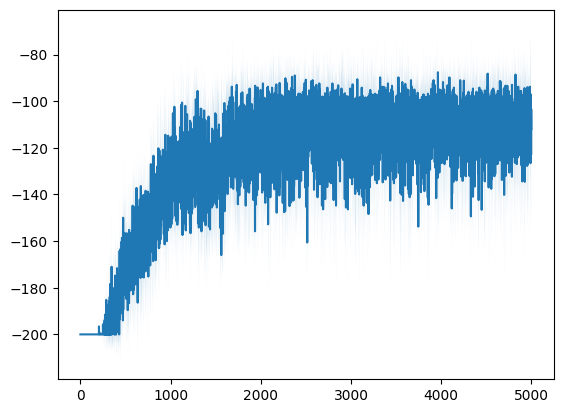

In [ ]:
import matplotlib.pyplot as plt
plt.plot(mean_rewards)
plt.fill_between(range(len(mean_rewards)), mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2)

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Tiling:
    def __init__(self, env, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles

        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07
        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])

        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]

        self.tilings = self.createTilings()

    def createTilingGrid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

    def createTilings(self):
        return [self.createTilingGrid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]

    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]

class sarsaAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.0001, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.numTilings = numTilings
        self.numTiles = numTiles

        self.tiling = Tiling(env, numTilings, numTiles)
        self.numActions = self.env.action_space.n
        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))

    def reset_weights(self):
        """ Reset weights and epsilon before each independent training run """
        self.weights = np.zeros((self.numActions, self.numFeatures))
        self.epsilon = self.epsilon_start

    def featureVector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)

        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1

        return featureVector

    def getQvalues(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))

    def choose_epsilonGreedy_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        q_values = [self.getQvalues(state, a) for a in range(self.numActions)]
        return np.argmax(q_values)

    def update(self, state, action, reward, next_state, next_action):
        phi = self.featureVector(state, action)
        q_sa = self.getQvalues(state, action)
        q_next = self.getQvalues(next_state, next_action)

        td_target = reward + self.gamma * q_next
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

    def train(self, num_episodes, num_runs=5):
        all_rewards = np.zeros((num_runs, num_episodes))
        all_steps = np.zeros((num_runs, num_episodes))

        for run in range(num_runs):
            print(f"Run:{run+1}")
            self.reset_weights()  # Reset weights for each independent run

            for i in tqdm(range(num_episodes), desc=f"Run {run+1}/{num_runs}"):
                totalReward, steps = 0, 0
                state, _ = self.env.reset()
                action = self.choose_epsilonGreedy_action(state)
                done = False

                while not done:
                    next_state, reward, terminated, truncated, _ = self.env.step(action)
                    next_action = self.choose_epsilonGreedy_action(next_state)

                    self.update(state, action, reward, next_state, next_action)

                    state, action = next_state, next_action
                    totalReward += reward
                    steps += 1
                    done = terminated or truncated

                all_rewards[run, i] = totalReward
                all_steps[run, i] = steps

                self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
                if i % 100 == 0:
                    avg_reward = np.mean(all_rewards[run, max(0, i-100):i+1])
                    print(f"Episode {i}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Epsilon: {self.epsilon:.4f}")

        # Compute mean and standard deviation across runs
        mean_rewards = np.mean(all_rewards, axis=0)
        std_rewards = np.std(all_rewards, axis=0)
        mean_steps = np.mean(all_steps, axis=0)
        std_steps = np.std(all_steps, axis=0)

        return mean_rewards, std_rewards, mean_steps, std_steps

# Initialize environment and agent for MountainCar-v0
env = gym.make("MountainCar-v0")
agent = sarsaAgent(env, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.0001, numTilings=8, numTiles=10)

# Train the agent over multiple runs
mean_rewards, std_rewards, mean_steps, std_steps = agent.train(5000, num_runs=5)

print("Training complete. Mean rewards and standard deviations computed.")


Run:1


Run 1/5:   0%|          | 2/5000 [00:00<05:11, 16.02it/s]

Episode 0/5000, Avg Reward (Last 100): -200.00, Epsilon: 0.9950


Run 1/5:   2%|▏         | 103/5000 [00:08<08:23,  9.72it/s]

Episode 100/5000, Avg Reward (Last 100): -200.00, Epsilon: 0.6027


Run 1/5:   4%|▍         | 203/5000 [00:17<07:29, 10.67it/s]

Episode 200/5000, Avg Reward (Last 100): -199.12, Epsilon: 0.3651


Run 1/5:   6%|▌         | 302/5000 [00:29<07:36, 10.30it/s]

Episode 300/5000, Avg Reward (Last 100): -195.56, Epsilon: 0.2212


Run 1/5:   8%|▊         | 401/5000 [00:40<07:33, 10.15it/s]

Episode 400/5000, Avg Reward (Last 100): -187.12, Epsilon: 0.1340


Run 1/5:  10%|█         | 502/5000 [00:50<07:13, 10.37it/s]

Episode 500/5000, Avg Reward (Last 100): -175.16, Epsilon: 0.0812


Run 1/5:  12%|█▏        | 603/5000 [01:01<06:49, 10.73it/s]

Episode 600/5000, Avg Reward (Last 100): -167.96, Epsilon: 0.0492


Run 1/5:  14%|█▍        | 702/5000 [01:10<06:07, 11.69it/s]

Episode 700/5000, Avg Reward (Last 100): -154.50, Epsilon: 0.0298


Run 1/5:  16%|█▌        | 802/5000 [01:19<05:34, 12.55it/s]

Episode 800/5000, Avg Reward (Last 100): -148.50, Epsilon: 0.0180


Run 1/5:  18%|█▊        | 902/5000 [01:28<05:20, 12.80it/s]

Episode 900/5000, Avg Reward (Last 100): -143.70, Epsilon: 0.0109


Run 1/5:  20%|██        | 1003/5000 [01:37<05:00, 13.29it/s]

Episode 1000/5000, Avg Reward (Last 100): -134.88, Epsilon: 0.0066


Run 1/5:  22%|██▏       | 1102/5000 [01:45<08:18,  7.82it/s]

Episode 1100/5000, Avg Reward (Last 100): -127.40, Epsilon: 0.0040


Run 1/5:  24%|██▍       | 1203/5000 [01:52<04:46, 13.27it/s]

Episode 1200/5000, Avg Reward (Last 100): -123.78, Epsilon: 0.0024


Run 1/5:  26%|██▌       | 1303/5000 [02:00<04:29, 13.72it/s]

Episode 1300/5000, Avg Reward (Last 100): -116.22, Epsilon: 0.0015


Run 1/5:  28%|██▊       | 1403/5000 [02:07<04:27, 13.44it/s]

Episode 1400/5000, Avg Reward (Last 100): -127.13, Epsilon: 0.0009


Run 1/5:  30%|███       | 1504/5000 [02:15<03:40, 15.84it/s]

Episode 1500/5000, Avg Reward (Last 100): -120.48, Epsilon: 0.0005


Run 1/5:  32%|███▏      | 1602/5000 [02:23<04:19, 13.10it/s]

Episode 1600/5000, Avg Reward (Last 100): -121.94, Epsilon: 0.0003


Run 1/5:  34%|███▍      | 1704/5000 [02:30<03:29, 15.73it/s]

Episode 1700/5000, Avg Reward (Last 100): -117.60, Epsilon: 0.0002


Run 1/5:  36%|███▌      | 1803/5000 [02:38<03:56, 13.55it/s]

Episode 1800/5000, Avg Reward (Last 100): -117.35, Epsilon: 0.0001


Run 1/5:  38%|███▊      | 1903/5000 [02:45<03:17, 15.66it/s]

Episode 1900/5000, Avg Reward (Last 100): -114.23, Epsilon: 0.0001


Run 1/5:  40%|████      | 2002/5000 [02:53<03:50, 13.01it/s]

Episode 2000/5000, Avg Reward (Last 100): -121.74, Epsilon: 0.0001


Run 1/5:  42%|████▏     | 2103/5000 [03:00<03:15, 14.85it/s]

Episode 2100/5000, Avg Reward (Last 100): -109.98, Epsilon: 0.0001


Run 1/5:  44%|████▍     | 2202/5000 [03:06<02:48, 16.61it/s]

Episode 2200/5000, Avg Reward (Last 100): -110.67, Epsilon: 0.0001


Run 1/5:  46%|████▌     | 2303/5000 [03:14<03:09, 14.25it/s]

Episode 2300/5000, Avg Reward (Last 100): -117.02, Epsilon: 0.0001


Run 1/5:  48%|████▊     | 2403/5000 [03:21<02:39, 16.30it/s]

Episode 2400/5000, Avg Reward (Last 100): -111.69, Epsilon: 0.0001


Run 1/5:  50%|█████     | 2502/5000 [03:28<02:55, 14.24it/s]

Episode 2500/5000, Avg Reward (Last 100): -115.45, Epsilon: 0.0001


Run 1/5:  52%|█████▏    | 2603/5000 [03:36<04:05,  9.77it/s]

Episode 2600/5000, Avg Reward (Last 100): -111.83, Epsilon: 0.0001


Run 1/5:  54%|█████▍    | 2704/5000 [03:43<02:38, 14.53it/s]

Episode 2700/5000, Avg Reward (Last 100): -114.94, Epsilon: 0.0001


Run 1/5:  56%|█████▌    | 2803/5000 [03:51<02:07, 17.25it/s]

Episode 2800/5000, Avg Reward (Last 100): -121.25, Epsilon: 0.0001


Run 1/5:  58%|█████▊    | 2902/5000 [03:57<02:21, 14.87it/s]

Episode 2900/5000, Avg Reward (Last 100): -109.70, Epsilon: 0.0001


Run 1/5:  60%|██████    | 3004/5000 [04:05<01:59, 16.65it/s]

Episode 3000/5000, Avg Reward (Last 100): -108.69, Epsilon: 0.0001


Run 1/5:  62%|██████▏   | 3102/5000 [04:11<02:32, 12.44it/s]

Episode 3100/5000, Avg Reward (Last 100): -106.99, Epsilon: 0.0001


Run 1/5:  64%|██████▍   | 3203/5000 [04:18<01:45, 17.02it/s]

Episode 3200/5000, Avg Reward (Last 100): -109.52, Epsilon: 0.0001


Run 1/5:  66%|██████▌   | 3304/5000 [04:26<01:57, 14.43it/s]

Episode 3300/5000, Avg Reward (Last 100): -113.83, Epsilon: 0.0001


Run 1/5:  68%|██████▊   | 3402/5000 [04:32<01:52, 14.19it/s]

Episode 3400/5000, Avg Reward (Last 100): -106.21, Epsilon: 0.0001


Run 1/5:  70%|███████   | 3503/5000 [04:40<01:40, 14.92it/s]

Episode 3500/5000, Avg Reward (Last 100): -113.49, Epsilon: 0.0001


Run 1/5:  72%|███████▏  | 3603/5000 [04:46<01:32, 15.10it/s]

Episode 3600/5000, Avg Reward (Last 100): -106.04, Epsilon: 0.0001


Run 1/5:  74%|███████▍  | 3704/5000 [04:55<01:26, 15.05it/s]

Episode 3700/5000, Avg Reward (Last 100): -111.34, Epsilon: 0.0001


Run 1/5:  76%|███████▌  | 3801/5000 [05:01<01:30, 13.29it/s]

Episode 3800/5000, Avg Reward (Last 100): -107.37, Epsilon: 0.0001


Run 1/5:  78%|███████▊  | 3903/5000 [05:09<01:09, 15.83it/s]

Episode 3900/5000, Avg Reward (Last 100): -110.88, Epsilon: 0.0001


Run 1/5:  80%|████████  | 4003/5000 [05:16<01:07, 14.70it/s]

Episode 4000/5000, Avg Reward (Last 100): -112.10, Epsilon: 0.0001


Run 1/5:  82%|████████▏ | 4104/5000 [05:23<00:57, 15.69it/s]

Episode 4100/5000, Avg Reward (Last 100): -109.56, Epsilon: 0.0001


Run 1/5:  84%|████████▍ | 4202/5000 [05:30<00:50, 15.93it/s]

Episode 4200/5000, Avg Reward (Last 100): -108.08, Epsilon: 0.0001


Run 1/5:  86%|████████▌ | 4304/5000 [05:37<00:42, 16.26it/s]

Episode 4300/5000, Avg Reward (Last 100): -108.48, Epsilon: 0.0001


Run 1/5:  88%|████████▊ | 4403/5000 [05:44<00:41, 14.32it/s]

Episode 4400/5000, Avg Reward (Last 100): -109.26, Epsilon: 0.0001


Run 1/5:  90%|█████████ | 4503/5000 [05:51<00:47, 10.39it/s]

Episode 4500/5000, Avg Reward (Last 100): -109.58, Epsilon: 0.0001


Run 1/5:  92%|█████████▏| 4604/5000 [05:58<00:23, 16.87it/s]

Episode 4600/5000, Avg Reward (Last 100): -108.05, Epsilon: 0.0001


Run 1/5:  94%|█████████▍| 4703/5000 [06:05<00:22, 13.01it/s]

Episode 4700/5000, Avg Reward (Last 100): -109.87, Epsilon: 0.0001


Run 1/5:  96%|█████████▌| 4804/5000 [06:12<00:12, 16.17it/s]

Episode 4800/5000, Avg Reward (Last 100): -108.38, Epsilon: 0.0001


Run 1/5:  98%|█████████▊| 4903/5000 [06:19<00:06, 14.94it/s]

Episode 4900/5000, Avg Reward (Last 100): -110.80, Epsilon: 0.0001


Run 1/5: 100%|██████████| 5000/5000 [06:25<00:00, 12.95it/s]


Run:2


Run 2/5:   0%|          | 2/5000 [00:00<05:02, 16.51it/s]

Episode 0/5000, Avg Reward (Last 100): -200.00, Epsilon: 0.9950


Run 2/5:   2%|▏         | 102/5000 [00:08<06:38, 12.28it/s]

Episode 100/5000, Avg Reward (Last 100): -200.00, Epsilon: 0.6027


Run 2/5:   4%|▍         | 203/5000 [00:18<07:34, 10.56it/s]

Episode 200/5000, Avg Reward (Last 100): -199.38, Epsilon: 0.3651


Run 2/5:   6%|▌         | 302/5000 [00:29<08:02,  9.73it/s]

Episode 300/5000, Avg Reward (Last 100): -194.06, Epsilon: 0.2212


Run 2/5:   8%|▊         | 402/5000 [00:40<13:24,  5.72it/s]

Episode 400/5000, Avg Reward (Last 100): -189.95, Epsilon: 0.1340


Run 2/5:  10%|█         | 502/5000 [00:49<07:00, 10.69it/s]

Episode 500/5000, Avg Reward (Last 100): -176.35, Epsilon: 0.0812


Run 2/5:  12%|█▏        | 602/5000 [01:00<06:46, 10.81it/s]

Episode 600/5000, Avg Reward (Last 100): -165.84, Epsilon: 0.0492


Run 2/5:  14%|█▍        | 703/5000 [01:10<06:22, 11.25it/s]

Episode 700/5000, Avg Reward (Last 100): -156.77, Epsilon: 0.0298


Run 2/5:  16%|█▌        | 802/5000 [01:19<05:38, 12.41it/s]

Episode 800/5000, Avg Reward (Last 100): -148.81, Epsilon: 0.0180


Run 2/5:  18%|█▊        | 902/5000 [01:27<07:28,  9.15it/s]

Episode 900/5000, Avg Reward (Last 100): -137.30, Epsilon: 0.0109


Run 2/5:  20%|██        | 1003/5000 [01:36<05:39, 11.78it/s]

Episode 1000/5000, Avg Reward (Last 100): -137.42, Epsilon: 0.0066


Run 2/5:  22%|██▏       | 1103/5000 [01:45<05:13, 12.43it/s]

Episode 1100/5000, Avg Reward (Last 100): -136.22, Epsilon: 0.0040


Run 2/5:  24%|██▍       | 1201/5000 [01:53<07:38,  8.29it/s]

Episode 1200/5000, Avg Reward (Last 100): -124.46, Epsilon: 0.0024


Run 2/5:  26%|██▌       | 1303/5000 [02:00<03:43, 16.52it/s]

Episode 1300/5000, Avg Reward (Last 100): -121.20, Epsilon: 0.0015


Run 2/5:  28%|██▊       | 1402/5000 [02:08<04:50, 12.39it/s]

Episode 1400/5000, Avg Reward (Last 100): -128.01, Epsilon: 0.0009


Run 2/5:  30%|███       | 1504/5000 [02:15<04:15, 13.66it/s]

Episode 1500/5000, Avg Reward (Last 100): -115.55, Epsilon: 0.0005


Run 2/5:  32%|███▏      | 1604/5000 [02:24<03:59, 14.19it/s]

Episode 1600/5000, Avg Reward (Last 100): -124.97, Epsilon: 0.0003


Run 2/5:  34%|███▍      | 1702/5000 [02:32<04:09, 13.22it/s]

Episode 1700/5000, Avg Reward (Last 100): -126.29, Epsilon: 0.0002


Run 2/5:  36%|███▌      | 1802/5000 [02:40<03:57, 13.49it/s]

Episode 1800/5000, Avg Reward (Last 100): -139.50, Epsilon: 0.0001


Run 2/5:  38%|███▊      | 1904/5000 [02:49<03:22, 15.32it/s]

Episode 1900/5000, Avg Reward (Last 100): -114.35, Epsilon: 0.0001


Run 2/5:  40%|████      | 2003/5000 [02:56<02:59, 16.67it/s]

Episode 2000/5000, Avg Reward (Last 100): -107.06, Epsilon: 0.0001


Run 2/5:  42%|████▏     | 2103/5000 [03:03<03:11, 15.14it/s]

Episode 2100/5000, Avg Reward (Last 100): -117.16, Epsilon: 0.0001


Run 2/5:  44%|████▍     | 2202/5000 [03:10<03:09, 14.79it/s]

Episode 2200/5000, Avg Reward (Last 100): -116.46, Epsilon: 0.0001


Run 2/5:  46%|████▌     | 2303/5000 [03:17<02:43, 16.49it/s]

Episode 2300/5000, Avg Reward (Last 100): -115.07, Epsilon: 0.0001


Run 2/5:  48%|████▊     | 2402/5000 [03:25<03:10, 13.65it/s]

Episode 2400/5000, Avg Reward (Last 100): -110.59, Epsilon: 0.0001


Run 2/5:  50%|█████     | 2502/5000 [03:32<03:25, 12.13it/s]

Episode 2500/5000, Avg Reward (Last 100): -112.10, Epsilon: 0.0001


Run 2/5:  52%|█████▏    | 2604/5000 [03:39<02:30, 15.90it/s]

Episode 2600/5000, Avg Reward (Last 100): -113.10, Epsilon: 0.0001


Run 2/5:  54%|█████▍    | 2704/5000 [03:46<02:18, 16.58it/s]

Episode 2700/5000, Avg Reward (Last 100): -112.45, Epsilon: 0.0001


Run 2/5:  56%|█████▌    | 2804/5000 [03:53<02:17, 15.95it/s]

Episode 2800/5000, Avg Reward (Last 100): -110.66, Epsilon: 0.0001


Run 2/5:  58%|█████▊    | 2904/5000 [04:00<02:13, 15.73it/s]

Episode 2900/5000, Avg Reward (Last 100): -110.33, Epsilon: 0.0001


Run 2/5:  60%|██████    | 3002/5000 [04:07<02:50, 11.74it/s]

Episode 3000/5000, Avg Reward (Last 100): -109.93, Epsilon: 0.0001


Run 2/5:  62%|██████▏   | 3103/5000 [04:14<01:55, 16.35it/s]

Episode 3100/5000, Avg Reward (Last 100): -108.49, Epsilon: 0.0001


Run 2/5:  64%|██████▍   | 3202/5000 [04:21<02:08, 13.95it/s]

Episode 3200/5000, Avg Reward (Last 100): -109.99, Epsilon: 0.0001


Run 2/5:  66%|██████▌   | 3304/5000 [04:28<01:47, 15.82it/s]

Episode 3300/5000, Avg Reward (Last 100): -111.59, Epsilon: 0.0001


Run 2/5:  68%|██████▊   | 3403/5000 [04:35<01:33, 17.13it/s]

Episode 3400/5000, Avg Reward (Last 100): -105.58, Epsilon: 0.0001


Run 2/5:  70%|███████   | 3503/5000 [04:41<01:45, 14.12it/s]

Episode 3500/5000, Avg Reward (Last 100): -108.23, Epsilon: 0.0001


Run 2/5:  72%|███████▏  | 3603/5000 [04:49<01:28, 15.73it/s]

Episode 3600/5000, Avg Reward (Last 100): -110.74, Epsilon: 0.0001


Run 2/5:  74%|███████▍  | 3701/5000 [04:56<02:06, 10.24it/s]

Episode 3700/5000, Avg Reward (Last 100): -115.48, Epsilon: 0.0001


Run 2/5:  76%|███████▌  | 3802/5000 [05:03<01:18, 15.20it/s]

Episode 3800/5000, Avg Reward (Last 100): -108.16, Epsilon: 0.0001


Run 2/5:  78%|███████▊  | 3903/5000 [05:11<01:16, 14.32it/s]

Episode 3900/5000, Avg Reward (Last 100): -105.58, Epsilon: 0.0001


Run 2/5:  80%|████████  | 4002/5000 [05:17<01:06, 15.07it/s]

Episode 4000/5000, Avg Reward (Last 100): -109.18, Epsilon: 0.0001


Run 2/5:  82%|████████▏ | 4103/5000 [05:25<00:59, 15.02it/s]

Episode 4100/5000, Avg Reward (Last 100): -109.04, Epsilon: 0.0001


Run 2/5:  84%|████████▍ | 4203/5000 [05:31<00:51, 15.51it/s]

Episode 4200/5000, Avg Reward (Last 100): -112.95, Epsilon: 0.0001


Run 2/5:  86%|████████▌ | 4304/5000 [05:39<00:41, 16.58it/s]

Episode 4300/5000, Avg Reward (Last 100): -106.92, Epsilon: 0.0001


Run 2/5:  88%|████████▊ | 4402/5000 [05:46<01:00,  9.84it/s]

Episode 4400/5000, Avg Reward (Last 100): -111.50, Epsilon: 0.0001


Run 2/5:  90%|█████████ | 4503/5000 [05:53<00:31, 15.59it/s]

Episode 4500/5000, Avg Reward (Last 100): -113.33, Epsilon: 0.0001


Run 2/5:  92%|█████████▏| 4603/5000 [06:00<00:26, 14.76it/s]

Episode 4600/5000, Avg Reward (Last 100): -107.84, Epsilon: 0.0001


Run 2/5:  94%|█████████▍| 4704/5000 [06:07<00:16, 17.42it/s]

Episode 4700/5000, Avg Reward (Last 100): -105.56, Epsilon: 0.0001


Run 2/5:  96%|█████████▌| 4802/5000 [06:14<00:13, 14.21it/s]

Episode 4800/5000, Avg Reward (Last 100): -114.94, Epsilon: 0.0001


Run 2/5:  98%|█████████▊| 4903/5000 [06:21<00:06, 15.31it/s]

Episode 4900/5000, Avg Reward (Last 100): -113.52, Epsilon: 0.0001


Run 2/5: 100%|██████████| 5000/5000 [06:28<00:00, 12.86it/s]


Run:3


Run 3/5:   0%|          | 2/5000 [00:00<05:20, 15.60it/s]

Episode 0/5000, Avg Reward (Last 100): -200.00, Epsilon: 0.9950


Run 3/5:   2%|▏         | 102/5000 [00:08<07:22, 11.06it/s]

Episode 100/5000, Avg Reward (Last 100): -200.00, Epsilon: 0.6027


Run 3/5:   4%|▍         | 202/5000 [00:17<07:50, 10.20it/s]

Episode 200/5000, Avg Reward (Last 100): -200.00, Epsilon: 0.3651


Run 3/5:   6%|▌         | 302/5000 [00:28<07:52,  9.94it/s]

Episode 300/5000, Avg Reward (Last 100): -196.18, Epsilon: 0.2212


Run 3/5:   8%|▊         | 402/5000 [00:40<07:37, 10.05it/s]

Episode 400/5000, Avg Reward (Last 100): -185.58, Epsilon: 0.1340


Run 3/5:  10%|█         | 502/5000 [00:52<06:52, 10.92it/s]

Episode 500/5000, Avg Reward (Last 100): -177.81, Epsilon: 0.0812


Run 3/5:  12%|█▏        | 602/5000 [01:02<06:40, 10.99it/s]

Episode 600/5000, Avg Reward (Last 100): -165.27, Epsilon: 0.0492


Run 3/5:  14%|█▍        | 702/5000 [01:12<05:56, 12.05it/s]

Episode 700/5000, Avg Reward (Last 100): -155.17, Epsilon: 0.0298


Run 3/5:  16%|█▌        | 801/5000 [01:21<08:37,  8.11it/s]

Episode 800/5000, Avg Reward (Last 100): -146.88, Epsilon: 0.0180


Run 3/5:  18%|█▊        | 903/5000 [01:30<05:59, 11.39it/s]

Episode 900/5000, Avg Reward (Last 100): -143.91, Epsilon: 0.0109


Run 3/5:  20%|██        | 1004/5000 [01:39<04:44, 14.07it/s]

Episode 1000/5000, Avg Reward (Last 100): -141.86, Epsilon: 0.0066


Run 3/5:  22%|██▏       | 1102/5000 [01:47<04:40, 13.90it/s]

Episode 1100/5000, Avg Reward (Last 100): -127.99, Epsilon: 0.0040


Run 3/5:  24%|██▍       | 1202/5000 [01:55<05:21, 11.80it/s]

Episode 1200/5000, Avg Reward (Last 100): -126.22, Epsilon: 0.0024


Run 3/5:  26%|██▌       | 1302/5000 [02:03<04:42, 13.11it/s]

Episode 1300/5000, Avg Reward (Last 100): -124.07, Epsilon: 0.0015


Run 3/5:  28%|██▊       | 1404/5000 [02:12<04:17, 13.96it/s]

Episode 1400/5000, Avg Reward (Last 100): -129.58, Epsilon: 0.0009


Run 3/5:  30%|███       | 1504/5000 [02:19<03:50, 15.16it/s]

Episode 1500/5000, Avg Reward (Last 100): -121.77, Epsilon: 0.0005


Run 3/5:  32%|███▏      | 1604/5000 [02:27<03:49, 14.81it/s]

Episode 1600/5000, Avg Reward (Last 100): -113.72, Epsilon: 0.0003


Run 3/5:  34%|███▍      | 1702/5000 [02:34<05:54,  9.31it/s]

Episode 1700/5000, Avg Reward (Last 100): -118.80, Epsilon: 0.0002


Run 3/5:  36%|███▌      | 1803/5000 [02:42<03:31, 15.11it/s]

Episode 1800/5000, Avg Reward (Last 100): -119.11, Epsilon: 0.0001


Run 3/5:  38%|███▊      | 1903/5000 [02:50<03:22, 15.32it/s]

Episode 1900/5000, Avg Reward (Last 100): -117.18, Epsilon: 0.0001


Run 3/5:  40%|████      | 2003/5000 [02:57<03:22, 14.81it/s]

Episode 2000/5000, Avg Reward (Last 100): -109.30, Epsilon: 0.0001


Run 3/5:  42%|████▏     | 2103/5000 [03:04<03:27, 13.97it/s]

Episode 2100/5000, Avg Reward (Last 100): -112.69, Epsilon: 0.0001


Run 3/5:  44%|████▍     | 2201/5000 [03:11<04:23, 10.64it/s]

Episode 2200/5000, Avg Reward (Last 100): -111.15, Epsilon: 0.0001


Run 3/5:  46%|████▌     | 2302/5000 [03:18<03:08, 14.30it/s]

Episode 2300/5000, Avg Reward (Last 100): -114.37, Epsilon: 0.0001


Run 3/5:  48%|████▊     | 2404/5000 [03:26<02:43, 15.87it/s]

Episode 2400/5000, Avg Reward (Last 100): -110.68, Epsilon: 0.0001


Run 3/5:  50%|█████     | 2503/5000 [03:33<03:06, 13.42it/s]

Episode 2500/5000, Avg Reward (Last 100): -116.50, Epsilon: 0.0001


Run 3/5:  52%|█████▏    | 2602/5000 [03:40<02:43, 14.69it/s]

Episode 2600/5000, Avg Reward (Last 100): -110.88, Epsilon: 0.0001


Run 3/5:  54%|█████▍    | 2701/5000 [03:47<03:35, 10.69it/s]

Episode 2700/5000, Avg Reward (Last 100): -114.15, Epsilon: 0.0001


Run 3/5:  56%|█████▌    | 2803/5000 [03:55<02:52, 12.74it/s]

Episode 2800/5000, Avg Reward (Last 100): -113.85, Epsilon: 0.0001


Run 3/5:  58%|█████▊    | 2902/5000 [04:03<02:42, 12.95it/s]

Episode 2900/5000, Avg Reward (Last 100): -112.27, Epsilon: 0.0001


Run 3/5:  60%|██████    | 3004/5000 [04:09<02:09, 15.37it/s]

Episode 3000/5000, Avg Reward (Last 100): -111.20, Epsilon: 0.0001


Run 3/5:  62%|██████▏   | 3104/5000 [04:17<01:55, 16.35it/s]

Episode 3100/5000, Avg Reward (Last 100): -108.64, Epsilon: 0.0001


Run 3/5:  64%|██████▍   | 3202/5000 [04:23<02:10, 13.75it/s]

Episode 3200/5000, Avg Reward (Last 100): -114.26, Epsilon: 0.0001


Run 3/5:  66%|██████▌   | 3303/5000 [04:31<01:45, 16.10it/s]

Episode 3300/5000, Avg Reward (Last 100): -112.03, Epsilon: 0.0001


Run 3/5:  68%|██████▊   | 3403/5000 [04:39<02:23, 11.14it/s]

Episode 3400/5000, Avg Reward (Last 100): -109.97, Epsilon: 0.0001


Run 3/5:  70%|███████   | 3503/5000 [04:45<01:43, 14.43it/s]

Episode 3500/5000, Avg Reward (Last 100): -110.21, Epsilon: 0.0001


Run 3/5:  72%|███████▏  | 3603/5000 [04:53<01:35, 14.62it/s]

Episode 3600/5000, Avg Reward (Last 100): -110.98, Epsilon: 0.0001


Run 3/5:  74%|███████▍  | 3702/5000 [04:59<01:28, 14.64it/s]

Episode 3700/5000, Avg Reward (Last 100): -112.17, Epsilon: 0.0001


Run 3/5:  76%|███████▌  | 3803/5000 [05:08<01:12, 16.41it/s]

Episode 3800/5000, Avg Reward (Last 100): -108.86, Epsilon: 0.0001


Run 3/5:  78%|███████▊  | 3901/5000 [05:14<01:12, 15.18it/s]

Episode 3900/5000, Avg Reward (Last 100): -108.60, Epsilon: 0.0001


Run 3/5:  80%|████████  | 4004/5000 [05:22<01:07, 14.79it/s]

Episode 4000/5000, Avg Reward (Last 100): -112.60, Epsilon: 0.0001


Run 3/5:  82%|████████▏ | 4104/5000 [05:30<01:01, 14.54it/s]

Episode 4100/5000, Avg Reward (Last 100): -110.77, Epsilon: 0.0001


Run 3/5:  84%|████████▍ | 4204/5000 [05:36<00:49, 16.06it/s]

Episode 4200/5000, Avg Reward (Last 100): -106.46, Epsilon: 0.0001


Run 3/5:  86%|████████▌ | 4304/5000 [05:44<00:46, 15.00it/s]

Episode 4300/5000, Avg Reward (Last 100): -111.39, Epsilon: 0.0001


Run 3/5:  88%|████████▊ | 4403/5000 [05:50<00:39, 15.16it/s]

Episode 4400/5000, Avg Reward (Last 100): -115.09, Epsilon: 0.0001


Run 3/5:  90%|█████████ | 4503/5000 [05:58<00:33, 14.84it/s]

Episode 4500/5000, Avg Reward (Last 100): -107.99, Epsilon: 0.0001


Run 3/5:  92%|█████████▏| 4601/5000 [06:05<00:37, 10.59it/s]

Episode 4600/5000, Avg Reward (Last 100): -110.03, Epsilon: 0.0001


Run 3/5:  94%|█████████▍| 4702/5000 [06:12<00:22, 13.25it/s]

Episode 4700/5000, Avg Reward (Last 100): -107.59, Epsilon: 0.0001


Run 3/5:  96%|█████████▌| 4804/5000 [06:19<00:12, 15.74it/s]

Episode 4800/5000, Avg Reward (Last 100): -108.49, Epsilon: 0.0001


Run 3/5:  98%|█████████▊| 4904/5000 [06:26<00:06, 14.47it/s]

Episode 4900/5000, Avg Reward (Last 100): -110.75, Epsilon: 0.0001


Run 3/5: 100%|██████████| 5000/5000 [06:33<00:00, 12.71it/s]


Run:4


Run 4/5:   0%|          | 2/5000 [00:00<06:01, 13.83it/s]

Episode 0/5000, Avg Reward (Last 100): -200.00, Epsilon: 0.9950


Run 4/5:   2%|▏         | 102/5000 [00:07<09:05,  8.98it/s]

Episode 100/5000, Avg Reward (Last 100): -200.00, Epsilon: 0.6027


Run 4/5:   4%|▍         | 202/5000 [00:17<07:39, 10.43it/s]

Episode 200/5000, Avg Reward (Last 100): -199.53, Epsilon: 0.3651


Run 4/5:   6%|▌         | 302/5000 [00:28<07:30, 10.42it/s]

Episode 300/5000, Avg Reward (Last 100): -195.05, Epsilon: 0.2212


Run 4/5:   8%|▊         | 402/5000 [00:39<07:43,  9.92it/s]

Episode 400/5000, Avg Reward (Last 100): -186.07, Epsilon: 0.1340


Run 4/5:  10%|█         | 502/5000 [00:50<06:53, 10.88it/s]

Episode 500/5000, Avg Reward (Last 100): -179.38, Epsilon: 0.0812


Run 4/5:  12%|█▏        | 602/5000 [01:01<06:29, 11.30it/s]

Episode 600/5000, Avg Reward (Last 100): -162.85, Epsilon: 0.0492


Run 4/5:  14%|█▍        | 702/5000 [01:11<11:01,  6.50it/s]

Episode 700/5000, Avg Reward (Last 100): -158.05, Epsilon: 0.0298


Run 4/5:  16%|█▌        | 803/5000 [01:19<05:38, 12.40it/s]

Episode 800/5000, Avg Reward (Last 100): -147.42, Epsilon: 0.0180


Run 4/5:  18%|█▊        | 903/5000 [01:29<05:53, 11.60it/s]

Episode 900/5000, Avg Reward (Last 100): -150.74, Epsilon: 0.0109


Run 4/5:  20%|██        | 1002/5000 [01:39<05:51, 11.38it/s]

Episode 1000/5000, Avg Reward (Last 100): -145.59, Epsilon: 0.0066


Run 4/5:  22%|██▏       | 1102/5000 [01:48<09:12,  7.05it/s]

Episode 1100/5000, Avg Reward (Last 100): -138.03, Epsilon: 0.0040


Run 4/5:  24%|██▍       | 1202/5000 [01:55<05:18, 11.94it/s]

Episode 1200/5000, Avg Reward (Last 100): -121.94, Epsilon: 0.0024


Run 4/5:  26%|██▌       | 1303/5000 [02:03<04:02, 15.25it/s]

Episode 1300/5000, Avg Reward (Last 100): -116.50, Epsilon: 0.0015


Run 4/5:  28%|██▊       | 1401/5000 [02:10<05:22, 11.17it/s]

Episode 1400/5000, Avg Reward (Last 100): -124.46, Epsilon: 0.0009


Run 4/5:  30%|███       | 1502/5000 [02:19<04:09, 14.05it/s]

Episode 1500/5000, Avg Reward (Last 100): -124.20, Epsilon: 0.0005


Run 4/5:  32%|███▏      | 1602/5000 [02:27<03:38, 15.52it/s]

Episode 1600/5000, Avg Reward (Last 100): -113.54, Epsilon: 0.0003


Run 4/5:  34%|███▍      | 1704/5000 [02:34<03:48, 14.44it/s]

Episode 1700/5000, Avg Reward (Last 100): -115.82, Epsilon: 0.0002


Run 4/5:  36%|███▌      | 1802/5000 [02:41<03:51, 13.79it/s]

Episode 1800/5000, Avg Reward (Last 100): -115.99, Epsilon: 0.0001


Run 4/5:  38%|███▊      | 1903/5000 [02:50<06:11,  8.35it/s]

Episode 1900/5000, Avg Reward (Last 100): -120.77, Epsilon: 0.0001


Run 4/5:  40%|████      | 2002/5000 [02:58<03:52, 12.88it/s]

Episode 2000/5000, Avg Reward (Last 100): -115.04, Epsilon: 0.0001


Run 4/5:  42%|████▏     | 2103/5000 [03:06<03:33, 13.59it/s]

Episode 2100/5000, Avg Reward (Last 100): -116.98, Epsilon: 0.0001


Run 4/5:  44%|████▍     | 2202/5000 [03:14<06:00,  7.75it/s]

Episode 2200/5000, Avg Reward (Last 100): -115.02, Epsilon: 0.0001


Run 4/5:  46%|████▌     | 2303/5000 [03:20<03:04, 14.60it/s]

Episode 2300/5000, Avg Reward (Last 100): -106.83, Epsilon: 0.0001


Run 4/5:  48%|████▊     | 2404/5000 [03:28<02:54, 14.88it/s]

Episode 2400/5000, Avg Reward (Last 100): -111.36, Epsilon: 0.0001


Run 4/5:  50%|█████     | 2504/5000 [03:35<02:40, 15.55it/s]

Episode 2500/5000, Avg Reward (Last 100): -113.78, Epsilon: 0.0001


Run 4/5:  52%|█████▏    | 2603/5000 [03:43<02:35, 15.40it/s]

Episode 2600/5000, Avg Reward (Last 100): -108.83, Epsilon: 0.0001


Run 4/5:  54%|█████▍    | 2701/5000 [03:49<02:30, 15.31it/s]

Episode 2700/5000, Avg Reward (Last 100): -108.13, Epsilon: 0.0001


Run 4/5:  56%|█████▌    | 2802/5000 [03:57<02:17, 15.99it/s]

Episode 2800/5000, Avg Reward (Last 100): -112.55, Epsilon: 0.0001


Run 4/5:  58%|█████▊    | 2903/5000 [04:05<02:42, 12.91it/s]

Episode 2900/5000, Avg Reward (Last 100): -114.23, Epsilon: 0.0001


Run 4/5:  60%|██████    | 3003/5000 [04:12<02:03, 16.21it/s]

Episode 3000/5000, Avg Reward (Last 100): -111.17, Epsilon: 0.0001


Run 4/5:  62%|██████▏   | 3102/5000 [04:19<02:00, 15.69it/s]

Episode 3100/5000, Avg Reward (Last 100): -103.32, Epsilon: 0.0001


Run 4/5:  64%|██████▍   | 3202/5000 [04:26<02:18, 12.99it/s]

Episode 3200/5000, Avg Reward (Last 100): -112.49, Epsilon: 0.0001


Run 4/5:  66%|██████▌   | 3303/5000 [04:33<01:58, 14.32it/s]

Episode 3300/5000, Avg Reward (Last 100): -112.25, Epsilon: 0.0001


Run 4/5:  68%|██████▊   | 3402/5000 [04:40<03:06,  8.55it/s]

Episode 3400/5000, Avg Reward (Last 100): -107.39, Epsilon: 0.0001


Run 4/5:  70%|███████   | 3504/5000 [04:47<01:35, 15.65it/s]

Episode 3500/5000, Avg Reward (Last 100): -110.51, Epsilon: 0.0001


Run 4/5:  72%|███████▏  | 3603/5000 [04:55<01:24, 16.63it/s]

Episode 3600/5000, Avg Reward (Last 100): -110.96, Epsilon: 0.0001


Run 4/5:  74%|███████▍  | 3703/5000 [05:01<01:27, 14.84it/s]

Episode 3700/5000, Avg Reward (Last 100): -111.57, Epsilon: 0.0001


Run 4/5:  76%|███████▌  | 3804/5000 [05:09<01:14, 16.07it/s]

Episode 3800/5000, Avg Reward (Last 100): -107.45, Epsilon: 0.0001


Run 4/5:  78%|███████▊  | 3904/5000 [05:15<01:09, 15.88it/s]

Episode 3900/5000, Avg Reward (Last 100): -108.57, Epsilon: 0.0001


Run 4/5:  80%|████████  | 4003/5000 [05:23<01:13, 13.47it/s]

Episode 4000/5000, Avg Reward (Last 100): -110.26, Epsilon: 0.0001


Run 4/5:  82%|████████▏ | 4103/5000 [05:30<01:11, 12.57it/s]

Episode 4100/5000, Avg Reward (Last 100): -110.96, Epsilon: 0.0001


Run 4/5:  84%|████████▍ | 4204/5000 [05:37<00:47, 16.70it/s]

Episode 4200/5000, Avg Reward (Last 100): -106.50, Epsilon: 0.0001


Run 4/5:  86%|████████▌ | 4304/5000 [05:44<00:42, 16.28it/s]

Episode 4300/5000, Avg Reward (Last 100): -106.29, Epsilon: 0.0001


Run 4/5:  88%|████████▊ | 4404/5000 [05:51<00:37, 15.97it/s]

Episode 4400/5000, Avg Reward (Last 100): -111.05, Epsilon: 0.0001


Run 4/5:  90%|█████████ | 4504/5000 [05:58<00:32, 15.46it/s]

Episode 4500/5000, Avg Reward (Last 100): -108.18, Epsilon: 0.0001


Run 4/5:  92%|█████████▏| 4604/5000 [06:05<00:25, 15.77it/s]

Episode 4600/5000, Avg Reward (Last 100): -107.46, Epsilon: 0.0001


Run 4/5:  94%|█████████▍| 4702/5000 [06:12<00:20, 14.90it/s]

Episode 4700/5000, Avg Reward (Last 100): -111.43, Epsilon: 0.0001


Run 4/5:  96%|█████████▌| 4804/5000 [06:20<00:16, 11.95it/s]

Episode 4800/5000, Avg Reward (Last 100): -110.39, Epsilon: 0.0001


Run 4/5:  98%|█████████▊| 4904/5000 [06:26<00:06, 15.64it/s]

Episode 4900/5000, Avg Reward (Last 100): -112.60, Epsilon: 0.0001


Run 4/5: 100%|██████████| 5000/5000 [06:34<00:00, 12.69it/s]


Run:5


Run 5/5:   0%|          | 2/5000 [00:00<05:18, 15.70it/s]

Episode 0/5000, Avg Reward (Last 100): -200.00, Epsilon: 0.9950


Run 5/5:   2%|▏         | 102/5000 [00:07<07:00, 11.66it/s]

Episode 100/5000, Avg Reward (Last 100): -200.00, Epsilon: 0.6027


Run 5/5:   4%|▍         | 202/5000 [00:17<07:29, 10.68it/s]

Episode 200/5000, Avg Reward (Last 100): -199.66, Epsilon: 0.3651


Run 5/5:   6%|▌         | 303/5000 [00:29<07:37, 10.27it/s]

Episode 300/5000, Avg Reward (Last 100): -197.76, Epsilon: 0.2212


Run 5/5:   8%|▊         | 402/5000 [00:41<07:38, 10.03it/s]

Episode 400/5000, Avg Reward (Last 100): -188.39, Epsilon: 0.1340


Run 5/5:  10%|█         | 502/5000 [00:51<06:58, 10.74it/s]

Episode 500/5000, Avg Reward (Last 100): -171.11, Epsilon: 0.0812


Run 5/5:  12%|█▏        | 603/5000 [01:02<06:53, 10.63it/s]

Episode 600/5000, Avg Reward (Last 100): -157.23, Epsilon: 0.0492


Run 5/5:  14%|█▍        | 702/5000 [01:12<08:56,  8.01it/s]

Episode 700/5000, Avg Reward (Last 100): -158.73, Epsilon: 0.0298


Run 5/5:  16%|█▌        | 803/5000 [01:21<06:04, 11.52it/s]

Episode 800/5000, Avg Reward (Last 100): -153.74, Epsilon: 0.0180


Run 5/5:  18%|█▊        | 902/5000 [01:30<05:28, 12.49it/s]

Episode 900/5000, Avg Reward (Last 100): -150.48, Epsilon: 0.0109


Run 5/5:  20%|██        | 1003/5000 [01:40<06:11, 10.77it/s]

Episode 1000/5000, Avg Reward (Last 100): -138.64, Epsilon: 0.0066


Run 5/5:  22%|██▏       | 1103/5000 [01:49<06:32,  9.94it/s]

Episode 1100/5000, Avg Reward (Last 100): -142.86, Epsilon: 0.0040


Run 5/5:  24%|██▍       | 1203/5000 [01:56<04:42, 13.44it/s]

Episode 1200/5000, Avg Reward (Last 100): -129.51, Epsilon: 0.0024


Run 5/5:  26%|██▌       | 1304/5000 [02:05<04:12, 14.65it/s]

Episode 1300/5000, Avg Reward (Last 100): -125.94, Epsilon: 0.0015


Run 5/5:  28%|██▊       | 1402/5000 [02:13<07:24,  8.10it/s]

Episode 1400/5000, Avg Reward (Last 100): -122.89, Epsilon: 0.0009


Run 5/5:  30%|███       | 1503/5000 [02:21<04:05, 14.26it/s]

Episode 1500/5000, Avg Reward (Last 100): -127.86, Epsilon: 0.0005


Run 5/5:  32%|███▏      | 1602/5000 [02:28<04:02, 14.04it/s]

Episode 1600/5000, Avg Reward (Last 100): -114.53, Epsilon: 0.0003


Run 5/5:  34%|███▍      | 1702/5000 [02:35<03:47, 14.50it/s]

Episode 1700/5000, Avg Reward (Last 100): -121.63, Epsilon: 0.0002


Run 5/5:  36%|███▌      | 1802/5000 [02:43<03:50, 13.87it/s]

Episode 1800/5000, Avg Reward (Last 100): -114.71, Epsilon: 0.0001


Run 5/5:  38%|███▊      | 1903/5000 [02:51<03:08, 16.47it/s]

Episode 1900/5000, Avg Reward (Last 100): -111.12, Epsilon: 0.0001


Run 5/5:  40%|████      | 2003/5000 [02:58<03:38, 13.70it/s]

Episode 2000/5000, Avg Reward (Last 100): -114.57, Epsilon: 0.0001


Run 5/5:  42%|████▏     | 2103/5000 [03:05<03:30, 13.78it/s]

Episode 2100/5000, Avg Reward (Last 100): -115.72, Epsilon: 0.0001


Run 5/5:  44%|████▍     | 2202/5000 [03:12<02:59, 15.55it/s]

Episode 2200/5000, Avg Reward (Last 100): -115.08, Epsilon: 0.0001


Run 5/5:  46%|████▌     | 2303/5000 [03:21<03:01, 14.86it/s]

Episode 2300/5000, Avg Reward (Last 100): -124.01, Epsilon: 0.0001


Run 5/5:  48%|████▊     | 2402/5000 [03:28<03:10, 13.63it/s]

Episode 2400/5000, Avg Reward (Last 100): -115.05, Epsilon: 0.0001


Run 5/5:  50%|█████     | 2504/5000 [03:35<02:43, 15.29it/s]

Episode 2500/5000, Avg Reward (Last 100): -111.15, Epsilon: 0.0001


Run 5/5:  52%|█████▏    | 2604/5000 [03:43<02:25, 16.51it/s]

Episode 2600/5000, Avg Reward (Last 100): -114.58, Epsilon: 0.0001


Run 5/5:  54%|█████▍    | 2702/5000 [03:49<02:20, 16.30it/s]

Episode 2700/5000, Avg Reward (Last 100): -106.49, Epsilon: 0.0001


Run 5/5:  56%|█████▌    | 2803/5000 [03:57<02:16, 16.13it/s]

Episode 2800/5000, Avg Reward (Last 100): -110.32, Epsilon: 0.0001


Run 5/5:  58%|█████▊    | 2904/5000 [04:04<02:55, 11.95it/s]

Episode 2900/5000, Avg Reward (Last 100): -112.12, Epsilon: 0.0001


Run 5/5:  60%|██████    | 3004/5000 [04:11<02:13, 14.98it/s]

Episode 3000/5000, Avg Reward (Last 100): -111.47, Epsilon: 0.0001


Run 5/5:  62%|██████▏   | 3104/5000 [04:18<01:58, 16.01it/s]

Episode 3100/5000, Avg Reward (Last 100): -104.73, Epsilon: 0.0001


Run 5/5:  64%|██████▍   | 3203/5000 [04:24<01:50, 16.30it/s]

Episode 3200/5000, Avg Reward (Last 100): -104.52, Epsilon: 0.0001


Run 5/5:  66%|██████▌   | 3302/5000 [04:32<01:58, 14.28it/s]

Episode 3300/5000, Avg Reward (Last 100): -115.38, Epsilon: 0.0001


Run 5/5:  68%|██████▊   | 3402/5000 [04:39<01:42, 15.57it/s]

Episode 3400/5000, Avg Reward (Last 100): -114.45, Epsilon: 0.0001


Run 5/5:  70%|███████   | 3504/5000 [04:46<01:33, 16.07it/s]

Episode 3500/5000, Avg Reward (Last 100): -106.21, Epsilon: 0.0001


Run 5/5:  72%|███████▏  | 3602/5000 [04:53<02:39,  8.78it/s]

Episode 3600/5000, Avg Reward (Last 100): -106.20, Epsilon: 0.0001


Run 5/5:  74%|███████▍  | 3703/5000 [05:01<01:27, 14.84it/s]

Episode 3700/5000, Avg Reward (Last 100): -108.42, Epsilon: 0.0001


Run 5/5:  76%|███████▌  | 3803/5000 [05:08<01:12, 16.58it/s]

Episode 3800/5000, Avg Reward (Last 100): -113.74, Epsilon: 0.0001


Run 5/5:  78%|███████▊  | 3903/5000 [05:15<01:19, 13.85it/s]

Episode 3900/5000, Avg Reward (Last 100): -112.50, Epsilon: 0.0001


Run 5/5:  80%|████████  | 4003/5000 [05:22<01:03, 15.66it/s]

Episode 4000/5000, Avg Reward (Last 100): -107.75, Epsilon: 0.0001


Run 5/5:  82%|████████▏ | 4102/5000 [05:30<01:44,  8.63it/s]

Episode 4100/5000, Avg Reward (Last 100): -113.25, Epsilon: 0.0001


Run 5/5:  84%|████████▍ | 4204/5000 [05:37<00:52, 15.08it/s]

Episode 4200/5000, Avg Reward (Last 100): -110.81, Epsilon: 0.0001


Run 5/5:  86%|████████▌ | 4303/5000 [05:44<00:48, 14.26it/s]

Episode 4300/5000, Avg Reward (Last 100): -109.50, Epsilon: 0.0001


Run 5/5:  88%|████████▊ | 4403/5000 [05:51<00:39, 15.16it/s]

Episode 4400/5000, Avg Reward (Last 100): -112.54, Epsilon: 0.0001


Run 5/5:  90%|█████████ | 4503/5000 [05:58<00:34, 14.23it/s]

Episode 4500/5000, Avg Reward (Last 100): -111.78, Epsilon: 0.0001


Run 5/5:  92%|█████████▏| 4601/5000 [06:05<00:29, 13.48it/s]

Episode 4600/5000, Avg Reward (Last 100): -111.34, Epsilon: 0.0001


Run 5/5:  94%|█████████▍| 4704/5000 [06:13<00:19, 15.14it/s]

Episode 4700/5000, Avg Reward (Last 100): -111.50, Epsilon: 0.0001


Run 5/5:  96%|█████████▌| 4804/5000 [06:20<00:13, 14.08it/s]

Episode 4800/5000, Avg Reward (Last 100): -109.27, Epsilon: 0.0001


Run 5/5:  98%|█████████▊| 4904/5000 [06:27<00:06, 14.34it/s]

Episode 4900/5000, Avg Reward (Last 100): -110.55, Epsilon: 0.0001


Run 5/5: 100%|██████████| 5000/5000 [06:34<00:00, 12.67it/s]

Training complete. Mean rewards and standard deviations computed.


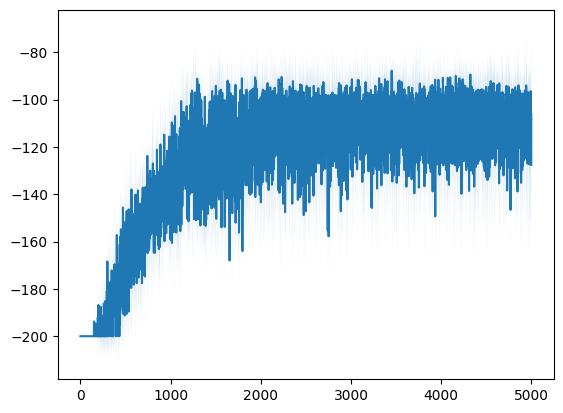

In [ ]:
plt.plot(mean_rewards)
plt.fill_between(range(len(mean_rewards)), mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2)

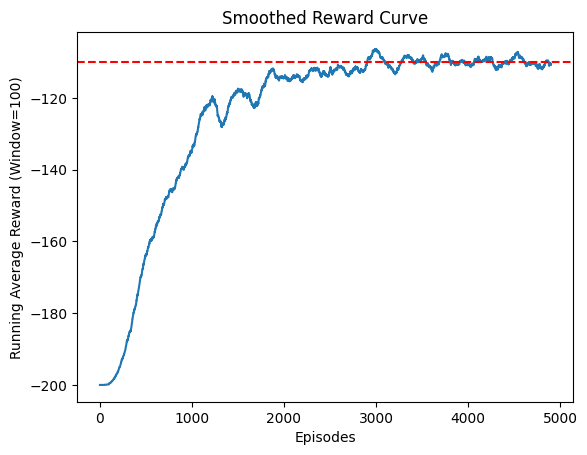

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Example usage
window_size = 100
smoothed_rewards = running_average(mean_rewards, window_size)

plt.plot(smoothed_rewards)
plt.xlabel("Episodes")

plt.axhline(y=-110, color='r', linestyle='--', label="Target Reward (-110)")
plt.ylabel("Running Average Reward (Window=100)")
plt.title("Smoothed Reward Curve")
plt.show()


In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Tiling:
    def __init__(self, env, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles

        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07
        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])

        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]

        self.tilings = self.createTilings()

    def createTilingGrid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

    def createTilings(self):
        return [self.createTilingGrid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]

    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.tau_start = tau_start
        self.tau_decay = tau_decay
        self.tau_min = tau_min

        self.numTilings = numTilings
        self.numTiles = numTiles

        self.tiling = Tiling(env, numTilings, numTiles)
        self.numActions = self.env.action_space.n

        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))

    def featureVector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)

        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1

        return featureVector
    def reset_weights(self):
        self.weights = np.zeros((self.numActions, self.numFeatures))
        self.tau = self.tau_start

    def getQvalue(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))

    def choose_action_softmax(self, state):
        q_values = np.array([self.getQvalue(state, a) for a in range(self.numActions)])
        exp_values = np.exp((q_values - np.max(q_values)) / self.tau)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(self.numActions, p=probs)

    def update(self, state, action, reward, next_state):
        phi = self.featureVector(state, action)
        q_sa = self.getQvalue(state, action)
        q_next_max = max([self.getQvalue(next_state, a) for a in range(self.numActions)])
        td_target = reward + self.gamma * q_next_max
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

def train(agent, env, num_episodes, num_runs=5):
    episode_rewards = np.zeros((num_runs, num_episodes))
    steps_to_completion = np.zeros((num_runs, num_episodes))

    for run in range(num_runs):
        print(f"Run:{run+1}")
        agent.reset_weights()
        # agent.weights = np.zeros((agent.numActions, agent.numFeatures))  # Reset weights for each run
        # tau = agent.tau_start  # Reset temperature for each run
        np.random.seed(run)
        for i in tqdm(range(num_episodes),desc=f"Run {run+1}/{num_runs}"):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            done = False

            while not done:
                action = agent.choose_action_softmax(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                agent.update(state, action, reward, next_state)

                state = next_state
                totalReward += reward
                steps += 1

            episode_rewards[run, i] = totalReward
            steps_to_completion[run, i] = steps

            agent.tau = max(agent.tau_min, agent.tau * agent.tau_decay)
            # if i % 100 == 0:
            #     avg_reward = np.mean(episode_rewards[run, max(0, i-100):i+1])
            #     print(f"Episode {i}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Tau: {agent.tau:.4f}")
        print(f"Final average reward;{np.mean(episode_rewards[run],axis=1)}")

    # Compute mean and standard deviation across runs
    mean_rewards = np.mean(episode_rewards, axis=0)
    std_rewards = np.std(episode_rewards, axis=0)
    mean_steps = np.mean(steps_to_completion, axis=0)
    std_steps = np.std(steps_to_completion, axis=0)

    return mean_rewards, std_rewards, mean_steps, std_steps

# Initialize environment and agent for MountainCar-v0
env = gym.make("MountainCar-v0")
agent = QLearningAgent(env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05, numTilings=8, numTiles=10)

# Train the agent over multiple runs
Q_mean_rewards, Q_std_rewards, Q_mean_steps, Q_std_steps = train(agent, env, 5000, num_runs=5)

print("Training complete. Mean rewards and standard deviations computed.")


Run:1


Run 1/5:   0%|          | 17/5000 [00:03<17:10,  4.84it/s]


KeyboardInterrupt: 

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Tiling:
    def __init__(self, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles

        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07
        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])

        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]

        self.tilings = self.createTilings()

    def createTilingGrid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

    def createTilings(self):
        return [self.createTilingGrid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]

    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]

class sarsaAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.0001, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.numTilings = numTilings
        self.numTiles = numTiles
        self.epsilon = epsilon_start

        self.tiling = Tiling(numTilings, numTiles)
        self.numActions = self.env.action_space.n
        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))

    def reset_weights(self):
        self.weights = np.zeros((self.numActions, self.numFeatures))
        self.epsilon = self.epsilon_start

    def featureVector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)

        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1

        return featureVector

    def getQvalues(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))

    def choose_epsilonGreedy_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        q_values = [self.getQvalues(state, a) for a in range(self.numActions)]
        return np.argmax(q_values)

    def update(self, state, action, reward, next_state, next_action):
        phi = self.featureVector(state, action)
        q_sa = self.getQvalues(state, action)
        q_next = self.getQvalues(next_state, next_action)

        td_target = reward + self.gamma * q_next
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

# Independent training function
def train(agent, env, num_episodes, num_runs=5):
    all_rewards = np.zeros((num_runs, num_episodes))
    all_steps = np.zeros((num_runs, num_episodes))

    for run in range(num_runs):
        # print(f"Run:{run+1}")
        agent.reset_weights()
        np.random.seed(run)
        for i in tqdm(range(num_episodes), desc=f"Run {run+1}/{num_runs}"):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            action = agent.choose_epsilonGreedy_action(state)
            done = False

            while not done:
                next_state, reward, terminated, truncated, _ = env.step(action)
                next_action = agent.choose_epsilonGreedy_action(next_state)

                agent.update(state, action, reward, next_state, next_action)

                state, action = next_state, next_action
                totalReward += reward
                steps += 1
                done = terminated or truncated

            all_rewards[run, i] = totalReward
            all_steps[run, i] = steps

            agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
            # if i % 100 == 0:
            #     avg_reward = np.mean(all_rewards[run, max(0, i-100):i+1])
            #     print(f"Episode {i}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Epsilon: {agent.epsilon:.4f}")
        print(f"Final average reward;{np.mean(all_rewards[run],axis=1)}")
    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)
    mean_steps = np.mean(all_steps, axis=0)
    std_steps = np.std(all_steps, axis=0)

    return mean_rewards, std_rewards, mean_steps, std_steps

# Initialize environment and agent
env = gym.make("MountainCar-v0")
agent = sarsaAgent(env, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.0001, numTilings=8, numTiles=10)

# Train the agent using the independent train function
sarsa_mean_rewards, sarsa_std_rewards, sarsa_mean_steps, sarsa_std_steps = train(agent, env, num_episodes=5000, num_runs=5)

print("Training complete. Mean rewards and standard deviations computed.")


Run 1/1: 100%|██████████| 500/500 [01:02<00:00,  7.96it/s]

Training complete. Mean rewards and standard deviations computed.


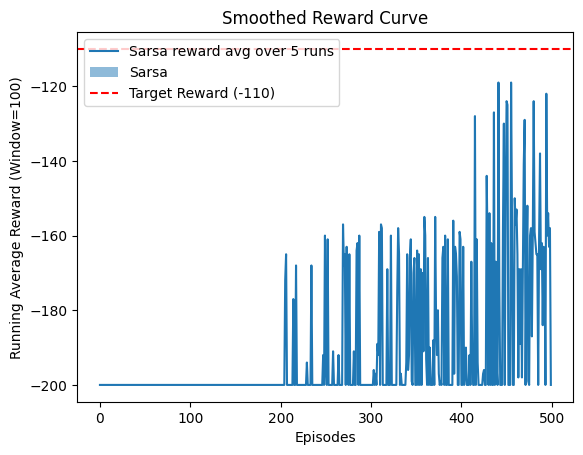

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sarsa_mean_rewards,label="Sarsa reward avg over 5 runs")
plt.fill_between(range(len(sarsa_mean_rewards)), sarsa_mean_rewards - sarsa_std_rewards, sarsa_mean_rewards + sarsa_std_rewards, alpha=0.5,label="Sarsa")
# plt.plot(Q_mean_rewards,label="Q learning reward avg over 5 runs")
# plt.fill_between(range(len(Q_mean_rewards)), Q_mean_rewards - Q_std_rewards, Q_mean_rewards + Q_std_rewards, alpha=0.5,label="Q-Learning")
plt.xlabel("Episodes")

plt.axhline(y=-110, color='r', linestyle='--', label="Target Reward (-110)")
plt.ylabel("Running Average Reward (Window=100)")
plt.title("Smoothed Reward Curve")

plt.legend()
plt.show()


In [ ]:
def running_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


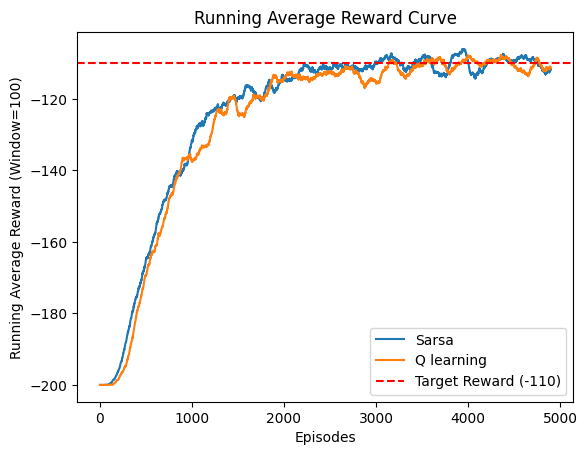

In [ ]:
plt.plot(running_average(sarsa_mean_rewards),label="Sarsa")
plt.plot(running_average(Q_mean_rewards),label="Q learning")
plt.axhline(y=-110, color='r', linestyle='--', label="Target Reward (-110)")
plt.xlabel("Episodes")
plt.ylabel("Running Average Reward (Window=100)")
plt.title("Running Average Reward Curve")
plt.legend()
plt.show()

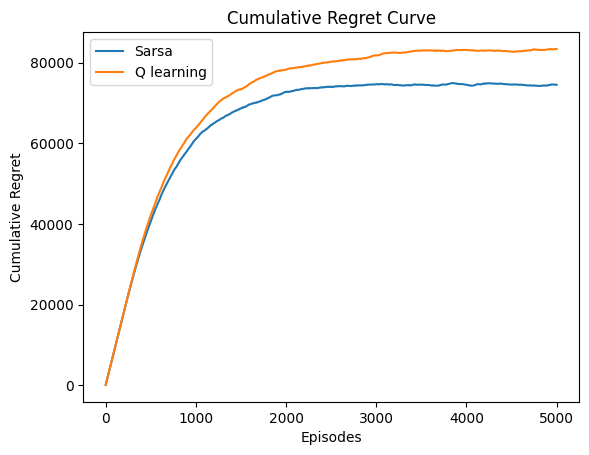

In [ ]:
sarsa_cumulative_regret = np.cumsum([-110 - i for i in sarsa_mean_rewards])
Q_cumulative_regret = np.cumsum([-110 - i for i in Q_mean_rewards])

# Plot results
plt.plot(sarsa_cumulative_regret, label="Sarsa")
plt.plot(Q_cumulative_regret, label="Q learning")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret Curve")
plt.legend()
plt.show()

In [ ]:

# Initialize environment and agent for MountainCar-v0
env = gym.make("MountainCar-v0")
agent = QLearningAgent(env, alpha=0.1, gamma=0.99, tau_start=5.0, tau_decay=0.9, tau_min=0.005, numTilings=8, numTiles=10)

# Train the agent over multiple runs
Q_mean_rewards, Q_std_rewards, Q_mean_steps, Q_std_steps = train(agent, env, 5000, num_runs=5)

print("Training complete. Mean rewards and standard deviations computed.")


TypeError: Tiling.__init__() takes from 1 to 3 positional arguments but 4 were given

In [ ]:

# Initialize environment and agent
env = gym.make("MountainCar-v0")
agent = sarsaAgent(env, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.9, epsilon_min=0.005, numTilings=8, numTiles=10)

# Train the agent using the independent train function
sarsa_mean_rewards, sarsa_std_rewards, sarsa_mean_steps, sarsa_std_steps = train(agent, env, num_episodes=5000, num_runs=5)

print("Training complete. Mean rewards and standard deviations computed.")


In [ ]:
!python mountain_car.py --algo q_learning --type tiling --n_episodes 1000 --n_runs 1


Running Q-Learning...
Run: 1
Run 1/1: 100% 1000/1000 [02:54<00:00,  5.72it/s]
Final average reward: -192.453
Training complete. Mean rewards and standard deviations computed.
Q-Learning Completed!

Saved plot: training_performance_1.png
Saved plot: running_average_1.png
Saved plot: cumulative_regret_1.png


In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Tiling:
    def __init__(self, env, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles

        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07
        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])

        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]

        self.tilings = self.createTilings()

    def createTilingGrid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

    def createTilings(self):
        return [self.createTilingGrid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]

    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.tau_start = tau_start
        self.tau_decay = tau_decay
        self.tau_min = tau_min
        self.tau = tau_start  # Initialize tau

        self.numTilings = numTilings
        self.numTiles = numTiles

        self.tiling = Tiling(env, numTilings, numTiles)
        self.numActions = self.env.action_space.n

        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))

    def featureVector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)

        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1

        return featureVector

    def reset_weights(self):
        self.weights = np.zeros((self.numActions, self.numFeatures))
        self.tau = self.tau_start  # Reset tau

    def getQvalue(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))

    def choose_action_softmax(self, state):
        q_values = np.array([self.getQvalue(state, a) for a in range(self.numActions)])
        exp_values = np.exp((q_values - np.max(q_values)) / self.tau)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(self.numActions, p=probs)

    def update(self, state, action, reward, next_state):
        phi = self.featureVector(state, action)
        q_sa = self.getQvalue(state, action)
        q_next_max = max([self.getQvalue(next_state, a) for a in range(self.numActions)])
        td_target = reward + self.gamma * q_next_max
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

def train(agent, env, num_episodes, num_runs=5):
    episode_rewards = np.zeros((num_runs, num_episodes))
    steps_to_completion = np.zeros((num_runs, num_episodes))

    for run in range(num_runs):
        print(f"Run: {run+1}")
        agent.reset_weights()
        np.random.seed(run)

        for i in tqdm(range(num_episodes), desc=f"Run {run+1}/{num_runs}"):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            done = False

            while not done:
                action = agent.choose_action_softmax(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                agent.update(state, action, reward, next_state)

                state = next_state
                totalReward += reward
                steps += 1

            episode_rewards[run, i] = totalReward
            steps_to_completion[run, i] = steps

            agent.tau = max(agent.tau_min, agent.tau * agent.tau_decay)

        print(f"Final average reward: {np.mean(episode_rewards[run])}")

    # Compute mean and standard deviation across runs
    mean_rewards = np.mean(episode_rewards, axis=0)
    std_rewards = np.std(episode_rewards, axis=0)
    mean_steps = np.mean(steps_to_completion, axis=0)
    std_steps = np.std(steps_to_completion, axis=0)

    return mean_rewards, std_rewards, mean_steps, std_steps

# Initialize environment and agent for MountainCar-v0
env = gym.make("MountainCar-v0")
agent = QLearningAgent(env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.9, tau_min=0.005, numTilings=15, numTiles=10)

# Train the agent over multiple runs
Q_mean_rewards, Q_std_rewards, Q_mean_steps, Q_std_steps = train(agent, env, 3500, num_runs=5)

print("Training complete. Mean rewards and standard deviations computed.")


Run: 1


Run 1/5: 100%|██████████| 3500/3500 [11:59<00:00,  4.87it/s]


Final average reward: -127.92885714285714
Run: 2


Run 2/5:  81%|████████▏ | 2850/3500 [10:06<02:18,  4.70it/s]


KeyboardInterrupt: 

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Tiling:
    def __init__(self, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles

        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07
        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])

        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]

        self.tilings = self.createTilings()

    def createTilingGrid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

    def createTilings(self):
        return [self.createTilingGrid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]

    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]

class sarsaAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.0001, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.numTilings = numTilings
        self.numTiles = numTiles
        self.epsilon = epsilon_start

        self.tiling = Tiling(numTilings, numTiles)
        self.numActions = self.env.action_space.n
        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))

    def reset_weights(self):
        self.weights = np.zeros((self.numActions, self.numFeatures))
        self.epsilon = self.epsilon_start

    def featureVector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)

        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1

        return featureVector

    def getQvalues(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))

    def choose_epsilonGreedy_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        q_values = [self.getQvalues(state, a) for a in range(self.numActions)]
        return np.argmax(q_values)

    def update(self, state, action, reward, next_state, next_action):
        phi = self.featureVector(state, action)
        q_sa = self.getQvalues(state, action)
        q_next = self.getQvalues(next_state, next_action)

        td_target = reward + self.gamma * q_next
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

# Independent training function
def train(agent, env, num_episodes, num_runs=5):
    all_rewards = np.zeros((num_runs, num_episodes))
    all_steps = np.zeros((num_runs, num_episodes))

    for run in range(num_runs):
        # print(f"Run:{run+1}")
        agent.reset_weights()
        np.random.seed(run)
        for i in tqdm(range(num_episodes), desc=f"Run {run+1}/{num_runs}"):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            action = agent.choose_epsilonGreedy_action(state)
            done = False

            while not done:
                next_state, reward, terminated, truncated, _ = env.step(action)
                next_action = agent.choose_epsilonGreedy_action(next_state)

                agent.update(state, action, reward, next_state, next_action)

                state, action = next_state, next_action
                totalReward += reward
                steps += 1
                done = terminated or truncated

            all_rewards[run, i] = totalReward
            all_steps[run, i] = steps

            agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
            # if i % 100 == 0:
            #     avg_reward = np.mean(all_rewards[run, max(0, i-100):i+1])
            #     print(f"Episode {i}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Epsilon: {agent.epsilon:.4f}")
        print(f"Final average reward: {np.mean(all_rewards[run])}")
    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)
    mean_steps = np.mean(all_steps, axis=0)
    std_steps = np.std(all_steps, axis=0)

    return mean_rewards, std_rewards, mean_steps, std_steps

# Initialize environment and agent
env = gym.make("MountainCar-v0")
agent = sarsaAgent(env, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.0001, numTilings=15, numTiles=10)

# Train the agent using the independent train function
sarsa_mean_rewards, sarsa_std_rewards, sarsa_mean_steps, sarsa_std_steps = train(agent, env, num_episodes=3500, num_runs=5)

print("Training complete. Mean rewards and standard deviations computed.")


Run 1/5: 100%|██████████| 3500/3500 [08:30<00:00,  6.86it/s]


Final average reward: -128.51542857142857


Run 2/5: 100%|██████████| 3500/3500 [08:33<00:00,  6.82it/s]


Final average reward: -128.59514285714286


Run 3/5: 100%|██████████| 3500/3500 [08:28<00:00,  6.89it/s]


Final average reward: -128.55485714285714


Run 4/5: 100%|██████████| 3500/3500 [08:24<00:00,  6.94it/s]


Final average reward: -127.746


Run 5/5: 100%|██████████| 3500/3500 [08:28<00:00,  6.88it/s]

Final average reward: -128.80971428571428
Training complete. Mean rewards and standard deviations computed.


In [ ]:
import subprocess

def generate_requirements(output_file="requirements.txt"):
    try:
        # Get list of installed packages
        result = subprocess.run(["pip", "freeze"], capture_output=True, text=True, check=True)

        # Save to requirements.txt if it doesn't exist
        try:
            with open(output_file, "x") as f:  # "x" mode ensures file is not overwritten
                f.write(result.stdout)
            print(f"Saved requirements to {output_file}")
        except FileExistsError:
            print(f"{output_file} already exists. Not overwriting.")

    except subprocess.CalledProcessError as e:
        print(f"Error generating requirements: {e}")

# Run the function
generate_requirements()


Saved requirements to requirements.txt


In [ ]:
|

In [ ]:
def running_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


In [ ]:
import matplotlib.pyplot as plt
plt.plot(running_average(sarsa_mean_rewards),label="Sarsa")
plt.plot(running_average(Q_mean_rewards),label="Q learning")
plt.axhline(y=-110, color='r', linestyle='--', label="Target Reward (-110)")
plt.xlabel("Episodes")
plt.ylabel("Running Average Reward (Window=100)")
plt.title("Running Average Reward Curve")
plt.legend()
plt.show()

In [ ]:
sarsa_cumulative_regret = np.cumsum([-110 - i for i in sarsa_mean_rewards])
Q_cumulative_regret = np.cumsum([-110 - i for i in Q_mean_rewards])

# Plot results
plt.plot(sarsa_cumulative_regret, label="Sarsa")
plt.plot(Q_cumulative_regret, label="Q learning")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret Curve")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sarsa_mean_rewards,label="Sarsa reward avg over 5 runs")
plt.fill_between(range(len(sarsa_mean_rewards)), sarsa_mean_rewards - sarsa_std_rewards, sarsa_mean_rewards + sarsa_std_rewards, alpha=0.5,label="Sarsa +/-1std")
plt.plot(Q_mean_rewards,label="Q learning reward avg over 5 runs")
plt.fill_between(range(len(Q_mean_rewards)), Q_mean_rewards - Q_std_rewards, Q_mean_rewards + Q_std_rewards, alpha=0.5,label="Q-Learning +/-1std")
plt.xlabel("Episodes")

plt.axhline(y=-110, color='r', linestyle='--', label="Target Reward (-110)")
plt.ylabel("Running Average Reward (Window=100)")
plt.title("Smoothed Reward Curve")

plt.legend()
plt.show()


In [ ]:
!python main.py --algo q_learning --type tiling --env_name MountainCar-v0 --n_episodes 1000


Running SARSA...
Run 1/5: 100% 1000/1000 [03:32<00:00,  4.70it/s]
Final average reward: -165.91
Run 2/5: 100% 1000/1000 [03:22<00:00,  4.94it/s]
Final average reward: -165.446
Run 3/5: 100% 1000/1000 [03:21<00:00,  4.96it/s]
Final average reward: -165.101
Run 4/5: 100% 1000/1000 [03:22<00:00,  4.95it/s]
Final average reward: -166.093
Run 5/5: 100% 1000/1000 [03:21<00:00,  4.96it/s]
Final average reward: -165.781
Training complete. Mean rewards and standard deviations computed.
SARSA Completed!

Saved plot: training_performance_1.png
Saved plot: running_average_1.png
Saved plot: cumulative_regret_1.png


In [ ]:
!python main.py --algo sarsa --type tiling --env_name MountainCar-v0 --n_episodes 1000

In [ ]:
!python main.py --algo q_learning --type tiling --env_name MountainCar-v0 --n_episodes 1000


Running Q-Learning...
Run: 1
Run 1/5: 100% 1000/1000 [04:35<00:00,  3.63it/s]
Final average reward: -165.142
Run: 2
Run 2/5: 100% 1000/1000 [04:34<00:00,  3.64it/s]
Final average reward: -165.285
Run: 3
Run 3/5: 100% 1000/1000 [04:34<00:00,  3.65it/s]
Final average reward: -165.668
Run: 4
Run 4/5: 100% 1000/1000 [04:36<00:00,  3.62it/s]
Final average reward: -166.54
Run: 5
Run 5/5: 100% 1000/1000 [04:35<00:00,  3.63it/s]
Final average reward: -166.227
Training complete. Mean rewards and standard deviations computed.
Q-Learning Completed!

Saved plot: training_performance_2.png
Saved plot: running_average_2.png
Saved plot: cumulative_regret_2.png


# Wandb


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m041 (cs24m041-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import wandb
sweep_config = {
    "method": "bayes",  # Can be "grid", "random", or "bayes"
    "metric": {
        "name": "cumulative regret",
        "goal": "minimize"
    },
    "parameters": {
        "algorithm": {
            "values": ["sarsa"]
        },
        "alpha": {
            "distribution": "log_uniform_values",
            "min": 0.0001,
            "max": 0.2
        },
        "gamma": {
            "distribution": "uniform",
            "min": 0.89,
            "max": 1.0
        },
        "epsilon_start": {
            "distribution": "uniform",
            "min": 0.6,
            "max": 1.0
        },
        "epsilon_decay": {
            "distribution": "log_uniform_values",
            "min": 0.9,
            "max": 0.9999
        },
        "epsilon_min": {
            "distribution": "uniform",
            "min": 0.0001,
            "max": 0.1
        },
        "numTilings": {
            "values": [4, 8, 16]
        },
        "numTiles": {
            "values": [5, 10, 20]
        },
        "num_episodes": {
            "distribution": "int_uniform",
            "min": 500,
            "max": 4999
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="Mountain car linear")  # Replace with your project name

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: qjrunylm
Sweep URL: https://wandb.ai/cs24m041-iit-madras/Mountain%20car%20linear/sweeps/qjrunylm


In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Tiling:
    def __init__(self, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles

        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07
        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])

        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]

        self.tilings = self.createTilings()

    def createTilingGrid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]

    def createTilings(self):
        return [self.createTilingGrid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]

    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]

class sarsaAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.0001, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.numTilings = numTilings
        self.numTiles = numTiles
        self.epsilon = epsilon_start

        self.tiling = Tiling(numTilings, numTiles)
        self.numActions = self.env.action_space.n
        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))

    def reset_weights(self):
        self.weights = np.zeros((self.numActions, self.numFeatures))
        self.epsilon = self.epsilon_start

    def featureVector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)

        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1

        return featureVector

    def getQvalues(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))

    def choose_epsilonGreedy_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        q_values = [self.getQvalues(state, a) for a in range(self.numActions)]
        return np.argmax(q_values)

    def update(self, state, action, reward, next_state, next_action):
        phi = self.featureVector(state, action)
        q_sa = self.getQvalues(state, action)
        q_next = self.getQvalues(next_state, next_action)

        td_target = reward + self.gamma * q_next
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

# Independent training function
def train(agent, env, num_episodes, num_runs=5):
    all_rewards = np.zeros((num_runs, num_episodes))
    all_steps = np.zeros((num_runs, num_episodes))

    for run in range(num_runs):
        # print(f"Run:{run+1}")
        agent.reset_weights()
        np.random.seed(run)
        for i in tqdm(range(num_episodes), desc=f"Run {run+1}/{num_runs}"):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            action = agent.choose_epsilonGreedy_action(state)
            done = False

            while not done:
                next_state, reward, terminated, truncated, _ = env.step(action)
                next_action = agent.choose_epsilonGreedy_action(next_state)

                agent.update(state, action, reward, next_state, next_action)

                state, action = next_state, next_action
                totalReward += reward
                steps += 1
                done = terminated or truncated

            all_rewards[run, i] = totalReward
            all_steps[run, i] = steps

            agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
            # if i % 100 == 0:
            #     avg_reward = np.mean(all_rewards[run, max(0, i-100):i+1])
            #     print(f"Episode {i}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Epsilon: {agent.epsilon:.4f}")
        # print(f"Final average reward;{np.mean(all_rewards[run],axis=1)}")
        print(f"Final average reward: {np.mean(all_rewards[run])}")
    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)
    mean_steps = np.mean(all_steps, axis=0)
    std_steps = np.std(all_steps, axis=0)

    return mean_rewards, std_rewards, mean_steps, std_steps


def wandb_run_sarsa():
    # Initialize wandb run
    wandb.init()
    config = wandb.config  # Access sweep parameters

    # Create environment
    env = gym.make("MountainCar-v0")

    # Sweep parameter: number of episodes
    num_episodes = config.num_episodes

    # Initialize agent
    agent = sarsaAgent(
        env,
        alpha=config.alpha,
        gamma=config.gamma,
        epsilon_start=config.epsilon_start,
        epsilon_decay=config.epsilon_decay,
        epsilon_min=config.epsilon_min,
        numTilings=config.numTilings,
        numTiles=config.numTiles
    )

    # Train the agent
    sarsa_mean_rewards, sarsa_std_rewards, sarsa_mean_steps, sarsa_std_steps = train(agent, env, num_episodes=num_episodes, num_runs=5)

    # Log averaged metrics to wandb at each episode
    cum_regret = 0
    for i in range(num_episodes):
        instant_regret = -110 - sarsa_mean_rewards[i]
        cum_regret += instant_regret
        wandb.log({
            "avg_reward": sarsa_mean_rewards[i],
            "reward_std": sarsa_std_rewards[i],
            "avg_cumulative_regret": cum_regret,
            "instantaneous_regret": instant_regret
        })

    # Log final results
    wandb.log({"final average reward": np.mean(sarsa_mean_rewards, axis=0)})
    wandb.log({"cumulative regret": cum_regret})

    # Return the results
    return sarsa_mean_rewards, sarsa_std_rewards, sarsa_mean_steps, sarsa_std_steps


In [ ]:

wandb.agent(sweep_id, function=wandb_run_sarsa, count=1)

wandb: Agent Starting Run: 6ma3n2ib with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.06211426351267313
wandb: 	epsilon_decay: 0.9654221506492277
wandb: 	epsilon_min: 0.02284168850582345
wandb: 	epsilon_start: 0.6861309582703312
wandb: 	gamma: 0.9799657278959236
wandb: 	numTiles: 5
wandb: 	numTilings: 8
wandb: 	num_episodes: 4905
wandb: Currently logged in as: cs24m041 (cs24m041-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Run 5/5: 100%|██████████| 4905/4905 [08:58<00:00,  9.11it/s]


avg_cumulative_regret,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇████
avg_reward,█▇▂▆▂▆▃▄▄▃▄▇▅▅▂▄▅▁▆▆▅█▄▄▇▇▆▇▂▃▄▆▄▄▆▅▄▆▇▃
cumulative regret,▁
final average reward,▁
instantaneous_regret,█▆▃▂▄▅▄▅▄▆▂▃▅▅▅▅▄▄▃▁▅▅▄▃▃▄▂▄▄▅▃▄▃▃▂▃▄▃▄▄
reward_std,▁▃▄▃▆▂▅▆▆▅▄▄▄▅▂█▂▅▅▄▆▅▆▃▂▅▅▅▄▄▄▅▂▃▇▂▅▅▄▂
avg_cumulative_regret,201416.8
avg_reward,-146
cumulative regret,201416.8
final average reward,-151.06357
instantaneous_regret,36


In [ ]:

wandb.agent(sweep_id, function=wandb_run_sarsa, count=25)

wandb: Agent Starting Run: f2twp0v5 with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.055988336643702306
wandb: 	epsilon_decay: 0.9164912079734392
wandb: 	epsilon_min: 0.013867901226069975
wandb: 	epsilon_start: 0.6632728225826862
wandb: 	gamma: 0.9426091587921318
wandb: 	numTiles: 20
wandb: 	numTilings: 4
wandb: 	num_episodes: 2472


Run 5/5: 100%|██████████| 2472/2472 [03:27<00:00, 11.91it/s]


avg_cumulative_regret,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇███
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▃▁▃▁▂▃▄▂▂▂▁▃▂▄█▅▅
cumulative regret,▁
final average reward,▁
instantaneous_regret,████████████████▆█▄███▃█▅██▃▇█▄▅█▅▇▂▁▆▃▃
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▄▁▁▁▄▄▁▅▁▁▁▅▁▅▅▆▅▅█▆█▅▅▇
avg_cumulative_regret,208505.6
avg_reward,-177.4
cumulative regret,208505.6
final average reward,-194.34693
instantaneous_regret,67.4


wandb: Agent Starting Run: b9p48h46 with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.013681405539653076
wandb: 	epsilon_decay: 0.998618106264548
wandb: 	epsilon_min: 0.09693012253673104
wandb: 	epsilon_start: 0.600434443435253
wandb: 	gamma: 0.9037386575919296
wandb: 	numTiles: 5
wandb: 	numTilings: 16
wandb: 	num_episodes: 2552


Run 5/5: 100%|██████████| 2552/2552 [10:38<00:00,  4.00it/s]


avg_cumulative_regret,▁▁▁▁▁▂▂▂▂▂▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
cumulative regret,▁
final average reward,▁
instantaneous_regret,████████████████████████▄████▅▁███████▆█
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▇▃▁▇▁▁▁▁▁▁▁▇▁▁█▁▁▁▁▁▁▁█▁▁▁▃▁
avg_cumulative_regret,226481.6
avg_reward,-199.6
cumulative regret,226481.6
final average reward,-198.74671
instantaneous_regret,89.6


wandb: Agent Starting Run: 6rscypns with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.04251379384742619
wandb: 	epsilon_decay: 0.952303139874206
wandb: 	epsilon_min: 0.034495701913544445
wandb: 	epsilon_start: 0.6605975936169727
wandb: 	gamma: 0.9720170190277796
wandb: 	numTiles: 10
wandb: 	numTilings: 16
wandb: 	num_episodes: 4113


Run 5/5: 100%|██████████| 4113/4113 [14:06<00:00,  4.86it/s]


avg_cumulative_regret,▁▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
avg_reward,▁▁▂▁▁▃▅▃▃▆▆▅▅▅▅▅▅▆▅▄▅▅▇▆▆▇▆█▆▆█▆███▆███▇
cumulative regret,▁
final average reward,▁
instantaneous_regret,███████▆▅▅▄▅▄▄▃▄▄▄▃▂▄▁▂▃▁▂▁▃▄▂▂▃▃▂▂▂▁▁▄▁
reward_std,▁▁▁▁▁▁▁▁▁▅▇▆▅▇▅▅▅▅▄▆▆▅▇▅▃▃▃▇▅▆▂▄▃▇▆▅▅▆█▇
avg_cumulative_regret,170975.4
avg_reward,-138.6
cumulative regret,170975.4
final average reward,-151.56951
instantaneous_regret,28.6


wandb: Agent Starting Run: 1j8xwm8g with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.008535384100848066
wandb: 	epsilon_decay: 0.918760704559469
wandb: 	epsilon_min: 0.010149703576369684
wandb: 	epsilon_start: 0.629718534789562
wandb: 	gamma: 0.9737786569732636
wandb: 	numTiles: 20
wandb: 	numTilings: 16
wandb: 	num_episodes: 3043


Run 5/5: 100%|██████████| 3043/3043 [14:12<00:00,  3.57it/s]


avg_cumulative_regret,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cumulative regret,▁
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,273863
avg_reward,-200
cumulative regret,273863
final average reward,-199.9977
instantaneous_regret,90


wandb: Agent Starting Run: m7kxpmrc with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.01357694450280427
wandb: 	epsilon_decay: 0.9763852990720614
wandb: 	epsilon_min: 0.0567873415526896
wandb: 	epsilon_start: 0.6581646658732963
wandb: 	gamma: 0.9875373586291306
wandb: 	numTiles: 20
wandb: 	numTilings: 16
wandb: 	num_episodes: 3950


Run 5/5: 100%|██████████| 3950/3950 [17:44<00:00,  3.71it/s]


avg_cumulative_regret,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁
cumulative regret,▁
final average reward,▁
instantaneous_regret,███████████████████████████▃████████▂██▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁
avg_cumulative_regret,354623.8
avg_reward,-193.6
cumulative regret,354623.8
final average reward,-199.77818
instantaneous_regret,83.6


wandb: Agent Starting Run: 1pluti2y with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.005394141199086574
wandb: 	epsilon_decay: 0.9886603710331896
wandb: 	epsilon_min: 0.012580856287565483
wandb: 	epsilon_start: 0.9460395896458328
wandb: 	gamma: 0.9739443134351592
wandb: 	numTiles: 5
wandb: 	numTilings: 16
wandb: 	num_episodes: 2323


Run 5/5: 100%|██████████| 2323/2323 [09:34<00:00,  4.04it/s]


avg_cumulative_regret,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▇▇▇▇▇▇████
avg_reward,▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▃▁▂▄▁▅▅▄▅▅▅▃▆▄▂▇▇█▂▃▇▇▆▇▆
cumulative regret,▁
final average reward,▁
instantaneous_regret,████████████████▇█▇▆▅▇█▅▆▄▄▃▆▂▅▃▃▁▇▁▄▂▄▄
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▄▆█▁▁▄█▆▇▇▇█▇▂▆█▇▇▆▆▃
avg_cumulative_regret,179974.2
avg_reward,-153.4
cumulative regret,179974.2
final average reward,-187.4749
instantaneous_regret,43.4


wandb: Agent Starting Run: d28k27w9 with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.005998106401960647
wandb: 	epsilon_decay: 0.9285818388755334
wandb: 	epsilon_min: 0.02460807273528204
wandb: 	epsilon_start: 0.9640937247180654
wandb: 	gamma: 0.937836596337511
wandb: 	numTiles: 20
wandb: 	numTilings: 4
wandb: 	num_episodes: 3984


Run 2/5:  69%|██████▊   | 2733/3984 [03:52<01:39, 12.59it/s]

In [ ]:

wandb.agent(sweep_id, function=wandb_run_sarsa, count=25)

In [ ]:

wandb.agent(sweep_id, function=wandb_run_sarsa)

In [ ]:
import wandb
import numpy as np
import gymnasium as gym

def wandb_run_sarsa():
    # Initialize wandb run
    wandb.init()
    config = wandb.config  # Access sweep parameters

    # Create environment
    env = gym.make("MountainCar-v0")

    # Sweep parameter: number of episodes
    num_episodes = config.num_episodes
    num_runs = 5  # Average over 5 runs

    # Storage for averaging across runs
    all_rewards = np.zeros((num_runs, num_episodes))
    all_steps = np.zeros((num_runs, num_episodes))
    all_cumulative_regrets = np.zeros((num_runs, num_episodes))

    # Run multiple independent trials
    for run in range(num_runs):
        print(f"Run:{run+1}")
        agent = sarsaAgent(
            env,
            alpha=config.alpha,
            gamma=config.gamma,
            epsilon_start=config.epsilon_start,
            epsilon_decay=config.epsilon_decay,
            epsilon_min=config.epsilon_min,
            numTilings=config.numTilings,
            numTiles=config.numTiles
        )

        # Reset agent weights
        agent.reset_weights()
        cumulative_regret = 0  # Reset cumulative regret per run

        for i in range(num_episodes):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            action = agent.choose_epsilonGreedy_action(state)
            done = False

            while not done:
                next_state, reward, terminated, truncated, info = env.step(action)
                next_action = agent.choose_epsilonGreedy_action(next_state)

                agent.update(state, action, reward, next_state, next_action)

                state, action = next_state, next_action
                totalReward += reward
                steps += 1
                done = terminated or truncated

            # Store rewards, steps, and regrets for averaging later
            all_rewards[run, i] = totalReward
            all_steps[run, i] = steps

            # Compute regret for this episode
            regret = -110 - totalReward  # Regret based on optimal policy
            cumulative_regret += regret
            all_cumulative_regrets[run, i] = cumulative_regret

            # Decay epsilon
            agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
            if i % 1000 == 0:
                avg_reward = np.mean(all_rewards[run, max(0, i-100):i+1])
                print(f"Episode {i}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.2f}, Epsilon: {agent.epsilon:.4f}")

    # Compute mean & std across runs at each episode
    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)
    mean_steps = np.mean(all_steps, axis=0)
    std_steps = np.std(all_steps, axis=0)
    mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)
    std_cumulative_regrets = np.std(all_cumulative_regrets, axis=0)

    # Log averaged metrics to wandb at each episode
    for i in range(num_episodes):
        wandb.log({
            "episode": i,
            "avg_reward": mean_rewards[i],
            "reward_std": std_rewards[i],
            "avg_cumulative_regret": mean_cumulative_regrets[i],
            "instantaneous_regret": mean_cumulative_regrets[i] - (mean_cumulative_regrets[i-1] if i > 0 else 0)
        })
    wandb.log({"final average reward": mean_rewards[-1]})
    wandb.log({"final average cumulative regret": mean_cumulative_regrets})
    return mean_rewards, std_rewards, mean_steps, std_steps


In [ ]:
!wandb login

wandb: Currently logged in as: cs24m041 (cs24m041-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
sweep_config = {
    "method": "bayes",  # Can be "grid", "random", or "bayes"
    "metric": {
        "name": "final average reward",
        "goal": "maximize"
    },
    "parameters": {
        "algorithm": {  # New parameter for flexibility
            "values": ["sarsa"]  # Add different RL algorithms
        },
        "alpha": {
            "distribution": "log_uniform_values",
            "min": 0.0001,
            "max": 0.5
        },
        "gamma": {
            "distribution": "uniform",
            "min": 0.8,
            "max": 1.0
        },
        "epsilon_start": {
            "distribution": "uniform",
            "min": 0.1,
            "max": 1.0
        },
        "epsilon_decay": {
            "distribution": "log_uniform_values",
            "min": 0.9,
            "max": 0.9999
        },
        "epsilon_min": {
            "distribution": "uniform",
            "min": 0.0001,
            "max": 0.1
        },
        "numTilings": {
            "values": [4, 8, 16]
        },
        "numTiles": {
            "values": [5, 10, 20]
        },
        "num_episodes": {
            "distribution": "int_uniform",
            "min": 500,
            "max": 4999
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="Mountain car linear")  # Replace with your project name

Create sweep with ID: dcj3x7sv
Sweep URL: https://wandb.ai/cs24m041-iit-madras/Mountain%20car%20linear/sweeps/dcj3x7sv


In [ ]:

wandb.agent(sweep_id, function=wandb_run_sarsa, count=1)

wandb: Agent Starting Run: 9xw7a1dd with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.3372417385349124
wandb: 	epsilon_decay: 0.9476987915238952
wandb: 	epsilon_min: 0.046828365142055024
wandb: 	epsilon_start: 0.9113349219806236
wandb: 	gamma: 0.8528717391055014
wandb: 	numTiles: 5
wandb: 	numTilings: 16
wandb: 	num_episodes: 500


avg_cumulative_regret,▁▁▁▁▁▂▂▂▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆██████
final average reward,▁
instantaneous_regret,███████▁████████▅███████████████████████
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,44901.6
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


In [ ]:

wandb.agent(sweep_id, function=wandb_run_sarsa, count=50)

wandb: Agent Starting Run: jamddjt4 with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.006021540210969228
wandb: 	epsilon_decay: 0.9456404009573212
wandb: 	epsilon_min: 0.032003123292252876
wandb: 	epsilon_start: 0.28861072063367005
wandb: 	gamma: 0.8839970289727271
wandb: 	numTiles: 5
wandb: 	numTilings: 16
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2729
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2729
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2729
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2729
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2729


avg_cumulative_regret,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇████
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▇▁▁▁▁
episode,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
avg_cumulative_regret,44981
avg_reward,-199.4
episode,499
final average reward,-199.4
instantaneous_regret,89.4


wandb: Agent Starting Run: 5ah1u4k3 with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.01266617129101098
wandb: 	epsilon_decay: 0.9076896446042192
wandb: 	epsilon_min: 0.09809384336239048
wandb: 	epsilon_start: 0.6171324632407513
wandb: 	gamma: 0.9408204186515045
wandb: 	numTiles: 5
wandb: 	numTilings: 4
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5602
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5602
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5602
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5602
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5602


avg_cumulative_regret,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▃▃▁▅▆▁▇▅▄█▁
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
final average reward,▁
instantaneous_regret,████████████████▇██████▅█▅████▃▇▇▇▄▁▅█▇█
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▂▅▁▆▁▁▂▁▁▄▇▁▁█
avg_cumulative_regret,44038.8
avg_reward,-189.4
episode,499
final average reward,-189.4
instantaneous_regret,79.4


wandb: Agent Starting Run: gey1es57 with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.011457667065341426
wandb: 	epsilon_decay: 0.9047404609517056
wandb: 	epsilon_min: 0.09802680126296325
wandb: 	epsilon_start: 0.5750439852952116
wandb: 	gamma: 0.927245635543783
wandb: 	numTiles: 10
wandb: 	numTilings: 4
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5203
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5203
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5203
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5203
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5203


avg_cumulative_regret,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇████
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,45000
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: hlgyx470 with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.0012787692055859598
wandb: 	epsilon_decay: 0.9447092817105908
wandb: 	epsilon_min: 0.003495743028894218
wandb: 	epsilon_start: 0.4324108025522406
wandb: 	gamma: 0.937241517649352
wandb: 	numTiles: 20
wandb: 	numTilings: 16
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.4085
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.4085
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.4085
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.4085
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.4085


avg_cumulative_regret,▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,45000
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: egr003r4 with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.12479414176034397
wandb: 	epsilon_decay: 0.9400088937921682
wandb: 	epsilon_min: 0.07220622729843705
wandb: 	epsilon_start: 0.2926122382563272
wandb: 	gamma: 0.860069382085644
wandb: 	numTiles: 5
wandb: 	numTilings: 8
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2751
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2751
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2751
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2751
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2751


avg_cumulative_regret,▁▁▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
avg_reward,▁▁▁▁▁▁▁▂▁▁▂▁▁▂▁▃▅▃▂▃▆▃▃▁▂▄▂▅▅▁▅▅▂▅█▃▅▄▂▄
episode,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
final average reward,▁
instantaneous_regret,██▇██▅█▄█▇▆██▃▇▃▃█▆▆▇▅▃▅▄▃▃▃▃▁▂▃▇▅█▄▇▅▄▅
reward_std,▁▁▂▁▃▁▁▁▁▁▆▇▃▇▆█▁▆█▇▅█▇▇▇▆▄▅▆▇▆▇▆▃▁▇▃▄█▅
avg_cumulative_regret,39211.6
avg_reward,-170.6
episode,499
final average reward,-170.6
instantaneous_regret,60.6


wandb: Agent Starting Run: c9lv9t7t with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.2574459814733116
wandb: 	epsilon_decay: 0.9213526221245868
wandb: 	epsilon_min: 0.08450029597934622
wandb: 	epsilon_start: 0.953285535321717
wandb: 	gamma: 0.831853330056691
wandb: 	numTiles: 10
wandb: 	numTilings: 4
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.8783
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.8783
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.8783
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.8783
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.8783


avg_cumulative_regret,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
avg_reward,▁▁▇▅▃▄▂▃▅▄▅▇▁▄▁▂▁▁▄▄▂▁█▂▂▁▂▂▁▂▅▁▁▄▁▁▁▁▁▁
episode,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
final average reward,▁
instantaneous_regret,████▇▅▅▆▂▁▇▅█▇██▆█▆█▆▆██████▃███████▆▅██
reward_std,▁▁▁▁▁▁▄▅█▄▃▆█▇▁▂▁▁▁▁▃▁▇▆▃▆▃▁▁▄▇▁▂▁▇▁█▁▁▁
avg_cumulative_regret,43037
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: smd946tq with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.0011630656215486966
wandb: 	epsilon_decay: 0.9584868978183924
wandb: 	epsilon_min: 0.09931534567788532
wandb: 	epsilon_start: 0.5406700086455403
wandb: 	gamma: 0.9331937045384224
wandb: 	numTiles: 10
wandb: 	numTilings: 4
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5182
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5182
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5182
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5182
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5182


avg_cumulative_regret,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇█████
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,45000
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: hm6lmz4h with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.25647091350901674
wandb: 	epsilon_decay: 0.9659388396436422
wandb: 	epsilon_min: 0.05664385076258412
wandb: 	epsilon_start: 0.5166633201999636
wandb: 	gamma: 0.9373498512989996
wandb: 	numTiles: 5
wandb: 	numTilings: 4
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.4991
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.4991
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.4991
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.4991
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.4991


avg_cumulative_regret,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
avg_reward,▁▁▁▁▁▁▅▃▁▅▃▃▇▇█▄▇▇▆▅▇▄▂▃▃▅▂▄▂▃▅▃▆▆▅▅▇▅▃▃
episode,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇▇████
final average reward,▁
instantaneous_regret,█████▇▆▁▇█▅▅▄▃▆▆▇▆▄▅▆▅▆▇▆▇▅▆▆▅██▅▃▄▆▃▆▅▅
reward_std,▁▁▁▁▁▂▇▅▄▆▆▅▄██▅▄▅▅▄▅█▅▅▄▅▁▁▃▅▆▅▅▅▆▂▄▄▅▅
avg_cumulative_regret,38329
avg_reward,-190.2
episode,499
final average reward,-190.2
instantaneous_regret,80.2


wandb: Agent Starting Run: daw2i2vq with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.003643957522053339
wandb: 	epsilon_decay: 0.9589348802613864
wandb: 	epsilon_min: 0.08158066792063047
wandb: 	epsilon_start: 0.7672322741911642
wandb: 	gamma: 0.933520585147735
wandb: 	numTiles: 5
wandb: 	numTilings: 16
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7357
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7357
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7357
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7357
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7357


avg_cumulative_regret,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,45000
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: esj50kmo with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.012110239992498405
wandb: 	epsilon_decay: 0.9459515421398208
wandb: 	epsilon_min: 0.03247904247996813
wandb: 	epsilon_start: 0.14252661045234
wandb: 	gamma: 0.9399985367927264
wandb: 	numTiles: 5
wandb: 	numTilings: 16
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.1348
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.1348
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.1348
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.1348
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.1348


avg_cumulative_regret,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▂▁▁▁▁▁▁▁▁▃▁▂█
episode,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█████
final average reward,▁
instantaneous_regret,████████████████████████▇████▇██▇▁█▇███▃
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▆▂█▁▁▆▁▂▇▇
avg_cumulative_regret,44686.4
avg_reward,-191
episode,499
final average reward,-191
instantaneous_regret,81


wandb: Agent Starting Run: ti2rnlmt with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.004128812928871636
wandb: 	epsilon_decay: 0.9935386388705384
wandb: 	epsilon_min: 0.06549007499882913
wandb: 	epsilon_start: 0.6152694705584695
wandb: 	gamma: 0.9119860907173144
wandb: 	numTiles: 10
wandb: 	numTilings: 8
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.6113
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.6113
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.6113
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.6113
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.6113


avg_cumulative_regret,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,45000
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: gmpv7gib with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.002053084027642072
wandb: 	epsilon_decay: 0.9860177756581384
wandb: 	epsilon_min: 0.056545126551516
wandb: 	epsilon_start: 0.23445572877467696
wandb: 	gamma: 0.9843395938457584
wandb: 	numTiles: 10
wandb: 	numTilings: 8
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2312
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2312
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2312
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2312
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2312


avg_cumulative_regret,▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇█████
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,45000
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: hbxb67rv with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.0005993204476920263
wandb: 	epsilon_decay: 0.9284958908922006
wandb: 	epsilon_min: 0.06531274291196759
wandb: 	epsilon_start: 0.3306473443155808
wandb: 	gamma: 0.8857424234629144
wandb: 	numTiles: 20
wandb: 	numTilings: 4
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.3070
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.3070
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.3070
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.3070
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.3070


avg_cumulative_regret,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇███
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,45000
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: 3gyylhza with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.00015345915231845412
wandb: 	epsilon_decay: 0.9437048006197843
wandb: 	epsilon_min: 0.02111069748514243
wandb: 	epsilon_start: 0.8298405697505379
wandb: 	gamma: 0.8518256110237512
wandb: 	numTiles: 20
wandb: 	numTilings: 4
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7831
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7831
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7831
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7831
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7831


avg_cumulative_regret,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▇▇▇▇▇████████
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,45000
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: tstjspgp with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.00010719477455918832
wandb: 	epsilon_decay: 0.950243730629274
wandb: 	epsilon_min: 0.04231539159541904
wandb: 	epsilon_start: 0.12235095144385263
wandb: 	gamma: 0.9996890225119154
wandb: 	numTiles: 5
wandb: 	numTilings: 16
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.1163
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.1163
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.1163
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.1163
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.1163


avg_cumulative_regret,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█████
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,45000
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: ry4yse3c with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.002107298070358025
wandb: 	epsilon_decay: 0.9908451785126288
wandb: 	epsilon_min: 0.03931739286194832
wandb: 	epsilon_start: 0.5559559977683592
wandb: 	gamma: 0.8404095733867786
wandb: 	numTiles: 20
wandb: 	numTilings: 8
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5509
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5509
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5509
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5509
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.5509


avg_cumulative_regret,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▁▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,45000
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: kx1wnszz with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.0007913948809450559
wandb: 	epsilon_decay: 0.9697167149855148
wandb: 	epsilon_min: 0.019570556498519825
wandb: 	epsilon_start: 0.25604679835283595
wandb: 	gamma: 0.8432492054957251
wandb: 	numTiles: 10
wandb: 	numTilings: 16
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2483
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2483
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2483
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2483
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2483


avg_cumulative_regret,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇█████
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█████
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,45000
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: v5ix7nyu with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.4456228716694619
wandb: 	epsilon_decay: 0.990230971250071
wandb: 	epsilon_min: 0.01486709550573566
wandb: 	epsilon_start: 0.7179229788612933
wandb: 	gamma: 0.884003043277154
wandb: 	numTiles: 5
wandb: 	numTilings: 4
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7109
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7109
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7109
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7109
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.7109


avg_cumulative_regret,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,44910.2
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: 5pfjvn1y with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.0008193191355040448
wandb: 	epsilon_decay: 0.95294279570332
wandb: 	epsilon_min: 0.07695552512328264
wandb: 	epsilon_start: 0.2642468295152129
wandb: 	gamma: 0.880433493310659
wandb: 	numTiles: 5
wandb: 	numTilings: 8
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2518
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2518
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2518
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2518
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.2518


avg_cumulative_regret,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇██
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,45000
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: 4lke9o1n with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.496025342914045
wandb: 	epsilon_decay: 0.9779569626530716
wandb: 	epsilon_min: 0.028022281640534333
wandb: 	epsilon_start: 0.6149900919041684
wandb: 	gamma: 0.9042931877194448
wandb: 	numTiles: 10
wandb: 	numTilings: 4
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.6014
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.6014
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.6014
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.6014
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.6014


avg_cumulative_regret,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
avg_reward,▁▁▁▁▁▁▁▁▁▁▄▁▆▂▆▄▁█▅▄▄▁▄▁▂▁▁▄▁▁▂▁▁▄▁▁▂▁▁▁
episode,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
final average reward,▁
instantaneous_regret,████▆███▆▂▇▆▆▆█▅█▃▃▃▁▅▆▁▆███████████▇▅██
reward_std,▁▁▁▁▁▁▄▁▂▁▄▅▆▅▄▁▅▅█▅▅▂▆▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
avg_cumulative_regret,42923.4
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: 9crcnw9y with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.006191806924451878
wandb: 	epsilon_decay: 0.9798385866306064
wandb: 	epsilon_min: 0.08691735586358221
wandb: 	epsilon_start: 0.8341130877927678
wandb: 	gamma: 0.9715123336229108
wandb: 	numTiles: 5
wandb: 	numTilings: 4
wandb: 	num_episodes: 500


Run:1
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.8173
Run:2
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.8173
Run:3
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.8173
Run:4
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.8173
Run:5
Episode 0/500, Avg Reward (Last 100): -200.00, Epsilon: 0.8173


avg_cumulative_regret,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁
episode,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇██
final average reward,▁
instantaneous_regret,█████████████████████████████████████▁██
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
avg_cumulative_regret,44963.8
avg_reward,-200
episode,499
final average reward,-200
instantaneous_regret,90


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:

wandb.agent(sweep_id, function=wandb_run_sarsa, count=50)

wandb: Agent Starting Run: kr5pp5rr with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.00031493391949764696
wandb: 	epsilon_decay: 0.9041791715683706
wandb: 	epsilon_min: 0.05460355220443613
wandb: 	epsilon_start: 0.377514815317913
wandb: 	gamma: 0.8173883360432491
wandb: 	numTiles: 20
wandb: 	numTilings: 4
wandb: 	num_episodes: 1132


Run:1
Episode 0/1132, Avg Reward (Last 100): -200.00, Epsilon: 0.3413
Episode 1000/1132, Avg Reward (Last 100): -200.00, Epsilon: 0.0546
Run:2
Episode 0/1132, Avg Reward (Last 100): -200.00, Epsilon: 0.3413
Episode 1000/1132, Avg Reward (Last 100): -200.00, Epsilon: 0.0546
Run:3
Episode 0/1132, Avg Reward (Last 100): -200.00, Epsilon: 0.3413
Episode 1000/1132, Avg Reward (Last 100): -200.00, Epsilon: 0.0546
Run:4
Episode 0/1132, Avg Reward (Last 100): -200.00, Epsilon: 0.3413
Episode 1000/1132, Avg Reward (Last 100): -200.00, Epsilon: 0.0546
Run:5
Episode 0/1132, Avg Reward (Last 100): -200.00, Epsilon: 0.3413
Episode 1000/1132, Avg Reward (Last 100): -200.00, Epsilon: 0.0546


avg_cumulative_regret,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,101880
avg_reward,-200
episode,1131
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: juodycdt with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.2733882829470447
wandb: 	epsilon_decay: 0.9524056291757784
wandb: 	epsilon_min: 0.025244391784871045
wandb: 	epsilon_start: 0.48347122444052104
wandb: 	gamma: 0.8476212599723221
wandb: 	numTiles: 20
wandb: 	numTilings: 4
wandb: 	num_episodes: 4608


Run:1
Episode 0/4608, Avg Reward (Last 100): -200.00, Epsilon: 0.4605
Episode 1000/4608, Avg Reward (Last 100): -177.85, Epsilon: 0.0252
Episode 2000/4608, Avg Reward (Last 100): -190.15, Epsilon: 0.0252
Episode 3000/4608, Avg Reward (Last 100): -199.40, Epsilon: 0.0252
Episode 4000/4608, Avg Reward (Last 100): -197.76, Epsilon: 0.0252
Run:2
Episode 0/4608, Avg Reward (Last 100): -200.00, Epsilon: 0.4605
Episode 1000/4608, Avg Reward (Last 100): -180.90, Epsilon: 0.0252
Episode 2000/4608, Avg Reward (Last 100): -191.89, Epsilon: 0.0252
Episode 3000/4608, Avg Reward (Last 100): -198.50, Epsilon: 0.0252
Episode 4000/4608, Avg Reward (Last 100): -198.05, Epsilon: 0.0252
Run:3
Episode 0/4608, Avg Reward (Last 100): -200.00, Epsilon: 0.4605
Episode 1000/4608, Avg Reward (Last 100): -185.15, Epsilon: 0.0252
Episode 2000/4608, Avg Reward (Last 100): -192.18, Epsilon: 0.0252
Episode 3000/4608, Avg Reward (Last 100): -197.93, Epsilon: 0.0252
Episode 4000/4608, Avg Reward (Last 100): -199.97, Ep

avg_cumulative_regret,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████
avg_reward,▁▃▅▆█▂▄▂▂▃▅▂▁▄▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁
episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇█████
final average reward,▁
instantaneous_regret,▄▄▂▁▂▂▁▂▁▃▇▅▅▄█▆█▆▇█▅▆▆████▇█▇█████▇████
reward_std,▅▇█▅█▅▅▃▃▂▂▂▆▆▅▃▁▁▄▄▁▅▁▁▁▁▃▁▁▁▁▁▁▁▁▂▁▁▁▁
avg_cumulative_regret,379513.8
avg_reward,-200
episode,4607
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: 5x5lzj7v with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.10493277347658168
wandb: 	epsilon_decay: 0.9653779596207898
wandb: 	epsilon_min: 0.08833415568022088
wandb: 	epsilon_start: 0.9792598981543305
wandb: 	gamma: 0.8035464794679854
wandb: 	numTiles: 5
wandb: 	numTilings: 8
wandb: 	num_episodes: 1626


Run:1
Episode 0/1626, Avg Reward (Last 100): -200.00, Epsilon: 0.9454
Episode 1000/1626, Avg Reward (Last 100): -199.55, Epsilon: 0.0883
Run:2
Episode 0/1626, Avg Reward (Last 100): -200.00, Epsilon: 0.9454
Episode 1000/1626, Avg Reward (Last 100): -200.00, Epsilon: 0.0883
Run:3
Episode 0/1626, Avg Reward (Last 100): -200.00, Epsilon: 0.9454
Episode 1000/1626, Avg Reward (Last 100): -183.10, Epsilon: 0.0883
Run:4
Episode 0/1626, Avg Reward (Last 100): -200.00, Epsilon: 0.9454
Episode 1000/1626, Avg Reward (Last 100): -189.54, Epsilon: 0.0883
Run:5
Episode 0/1626, Avg Reward (Last 100): -200.00, Epsilon: 0.9454
Episode 1000/1626, Avg Reward (Last 100): -182.90, Epsilon: 0.0883


avg_cumulative_regret,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
avg_reward,▁▁▁▃▃▅▄▄▇▁▄▅█▄▁▃▃▄▇▅▂▄▆▂▁▂▃▁▁▂▁▁▁▁▁▁▁▃▁▅
episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇██
final average reward,▁
instantaneous_regret,▆▄▃▁██▃█▅▄▂▂▅▄▂▃▃▂▆▄▇▇▇▆▆█▇█████████████
reward_std,▁▁▁▁▁▅▁▁▅▁▅▆██▄▃█▃▃▃▄▆▄▄▃▅▃▃▃▂▃▄▁▁▁▁▁▁▁▁
avg_cumulative_regret,133890.2
avg_reward,-200
episode,1625
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: yrxsvz2k with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.0044504786770167126
wandb: 	epsilon_decay: 0.9731990660209164
wandb: 	epsilon_min: 0.015542962448021308
wandb: 	epsilon_start: 0.8738743888873262
wandb: 	gamma: 0.8959080171854191
wandb: 	numTiles: 5
wandb: 	numTilings: 4
wandb: 	num_episodes: 2399


Run:1
Episode 0/2399, Avg Reward (Last 100): -200.00, Epsilon: 0.8505
Episode 1000/2399, Avg Reward (Last 100): -198.29, Epsilon: 0.0155
Episode 2000/2399, Avg Reward (Last 100): -193.10, Epsilon: 0.0155
Run:2
Episode 0/2399, Avg Reward (Last 100): -200.00, Epsilon: 0.8505
Episode 1000/2399, Avg Reward (Last 100): -199.15, Epsilon: 0.0155
Episode 2000/2399, Avg Reward (Last 100): -182.51, Epsilon: 0.0155
Run:3
Episode 0/2399, Avg Reward (Last 100): -200.00, Epsilon: 0.8505
Episode 1000/2399, Avg Reward (Last 100): -190.39, Epsilon: 0.0155
Episode 2000/2399, Avg Reward (Last 100): -138.55, Epsilon: 0.0155
Run:4
Episode 0/2399, Avg Reward (Last 100): -200.00, Epsilon: 0.8505
Episode 1000/2399, Avg Reward (Last 100): -197.68, Epsilon: 0.0155
Episode 2000/2399, Avg Reward (Last 100): -148.05, Epsilon: 0.0155
Run:5
Episode 0/2399, Avg Reward (Last 100): -200.00, Epsilon: 0.8505
Episode 1000/2399, Avg Reward (Last 100): -195.11, Epsilon: 0.0155
Episode 2000/2399, Avg Reward (Last 100): -124.

avg_cumulative_regret,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▆▄▁▂▄▅▅▂▅▅▄▄▄▄▅▇▅█▅▇▅▇▅▇
episode,▁▁▁▁▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
final average reward,▁
instantaneous_regret,███████████████▇█████▆▆▇▄▃▃▆▆▅▆▆▅▄▄▂▁▁▁▄
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▃▃▆▁▁▁▇▆▇▁▇█▇▇▇▇▇▃▅▇▆▆▇█
avg_cumulative_regret,170371
avg_reward,-142.2
episode,2398
final average reward,-142.2
instantaneous_regret,32.2


wandb: Agent Starting Run: 2vay7yem with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.0008540823387879854
wandb: 	epsilon_decay: 0.972381582383912
wandb: 	epsilon_min: 0.0797994952195091
wandb: 	epsilon_start: 0.33975284161861785
wandb: 	gamma: 0.9102360403448196
wandb: 	numTiles: 10
wandb: 	numTilings: 8
wandb: 	num_episodes: 3635


Run:1
Episode 0/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.3304
Episode 1000/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.0798
Episode 2000/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.0798
Episode 3000/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.0798
Run:2
Episode 0/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.3304
Episode 1000/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.0798
Episode 2000/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.0798
Episode 3000/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.0798
Run:3
Episode 0/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.3304
Episode 1000/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.0798
Episode 2000/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.0798
Episode 3000/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.0798
Run:4
Episode 0/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.3304
Episode 1000/3635, Avg Reward (Last 100): -200.00, Epsilon: 0.0798
Episode 2000/3635, Avg Reward (Last 100): -200.00,

avg_cumulative_regret,▁▁▂▂▂▂▂▂▂▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███████████
avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇███
final average reward,▁
instantaneous_regret,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_std,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_cumulative_regret,327150
avg_reward,-200
episode,3634
final average reward,-200
instantaneous_regret,90


wandb: Agent Starting Run: o41jo9n5 with config:
wandb: 	algorithm: sarsa
wandb: 	alpha: 0.000984182446887826
wandb: 	epsilon_decay: 0.9641964957307092
wandb: 	epsilon_min: 0.02857781320995158
wandb: 	epsilon_start: 0.5969469566934875
wandb: 	gamma: 0.905370905612944
wandb: 	numTiles: 5
wandb: 	numTilings: 8
wandb: 	num_episodes: 2093


Run:1
Episode 0/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.5756
Episode 1000/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.0286
Episode 2000/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.0286
Run:2
Episode 0/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.5756
Episode 1000/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.0286
Episode 2000/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.0286
Run:3
Episode 0/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.5756
Episode 1000/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.0286
Episode 2000/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.0286
Run:4
Episode 0/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.5756
Episode 1000/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.0286
Episode 2000/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.0286
Run:5
Episode 0/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.5756
Episode 1000/2093, Avg Reward (Last 100): -200.00, Epsilon: 0.0286


In [ ]:

wandb.agent(sweep_id, function=wandb_run_sarsa)

# cli


In [ ]:
%%writefile main.py

import numpy as np
import argparse
from collections import deque

import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

###############################################################Plotting
def get_unique_filename(base_filename):
    filename, ext = os.path.splitext(base_filename)
    counter = 1
    unique_filename = base_filename

    while os.path.exists(unique_filename):
        unique_filename = f"{filename}_{counter}{ext}"
        counter += 1

    return unique_filename

def plot_mean_std(avg_rewards, std_rewards, title="Training Performance", ylabel="Reward", filename="training_performance.png"):
    episodes = np.arange(len(avg_rewards))

    plt.figure()
    plt.plot(episodes, avg_rewards, label="Mean Reward", color="b", linewidth=2)
    plt.fill_between(episodes, avg_rewards - std_rewards, avg_rewards + std_rewards, color="b", alpha=0.2, label="±1 Std Dev")
    plt.xlabel("Episodes")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.6)

    unique_filename = get_unique_filename(filename)
    plt.savefig(unique_filename, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"Saved plot: {unique_filename}")

def plot_running_average(rewards, window_size=100, title="Running Average of Rewards", ylabel="Reward", filename="running_average.png"):
    episodes = np.arange(len(rewards))
    running_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')

    plt.figure()
    plt.plot(episodes, rewards, label="Original Rewards", color="gray", alpha=0.4)
    plt.plot(episodes[:len(running_avg)], running_avg, label=f"Running Avg ({window_size} episodes)", color="b", linewidth=2)
    plt.xlabel("Episodes")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    unique_filename = get_unique_filename(filename)
    plt.savefig(unique_filename, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"Saved plot: {unique_filename}")

def plot_cumulative_regret(target, avg_rw, filename="cumulative_regret.png"):
    optimal_rewards = np.full_like(avg_rw, target)
    cumulative_regret = np.cumsum(optimal_rewards - avg_rw)

    plt.figure()
    plt.plot(cumulative_regret, label="Cumulative Regret", color='red')
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Regret")
    plt.title("Cumulative Regret over Episodes")
    plt.legend()
    plt.grid()

    unique_filename = get_unique_filename(filename)
    plt.savefig(unique_filename, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"Saved plot: {unique_filename}")

def plot_cumulative_regret_both(target, q_learning_rewards, sarsa_rewards, labels=("Q-Learning", "SARSA")):
    optimal_rewards = np.full_like(q_learning_rewards, target)
    cumulative_regret_q = np.cumsum(optimal_rewards - q_learning_rewards)
    cumulative_regret_sarsa = np.cumsum(optimal_rewards - sarsa_rewards)
    plt.plot(cumulative_regret_q, label=f"Cumulative Regret ({labels[0]})", color='blue')
    plt.plot(cumulative_regret_sarsa, label=f"Cumulative Regret ({labels[1]})", color='red')
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Regret")
    plt.title("Cumulative Regret over Episodes (Q-Learning vs SARSA)")
    plt.legend()
    plt.grid()
    plt.show()
def plot_running_average_both(q_rewards, sarsa_rewards, window_size=100, labels=("Q-Learning", "SARSA")):
    episodes_q = np.arange(len(q_rewards))
    episodes_sarsa = np.arange(len(sarsa_rewards))
    running_avg_q = np.convolve(q_rewards, np.ones(window_size)/window_size, mode='valid')
    running_avg_sarsa = np.convolve(sarsa_rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(episodes_q, q_rewards, label=f"Original {labels[0]} Rewards", color="gray", alpha=0.3)
    plt.plot(episodes_q[:len(running_avg_q)], running_avg_q, label=f"Running Avg ({labels[0]})", color="b", linewidth=2)
    plt.plot(episodes_sarsa, sarsa_rewards, label=f"Original {labels[1]} Rewards", color="gray", alpha=0.3)
    plt.plot(episodes_sarsa[:len(running_avg_sarsa)], running_avg_sarsa, label=f"Running Avg ({labels[1]})", color="r", linewidth=2)
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Running Average of Rewards (Q-Learning vs SARSA)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()








###############################################################################Q Table
class Split_to_grid:
    def __init__(self, env, n_bins=(20, 20)):
        self.env = env
        self.n_bins = n_bins
        self.space_min = env.observation_space.low
        self.space_max = env.observation_space.high
        self.space_w = (self.space_max - self.space_min) / n_bins
    def find_the_cell(self, val):
        clip_val = np.clip(val, self.space_min, self.space_max)
        bi = np.floor((clip_val - self.space_min) / self.space_w).astype(int)
        bi = np.clip(bi, 0, np.array(self.n_bins) - 1)
        cell_no = bi[0] * self.n_bins[1] + bi[1]
        return cell_no

class Qagent:
    def __init__(self,num_states,num_actions,alpha,gamma,initial_tau,tau_decay,min_tau):
        self.n_states=num_states
        self.n_actions=num_actions
        self.alpha=alpha
        self.gamma= gamma
        self.tau = initial_tau
        self.tau_decay = tau_decay
        self.min_tau = min_tau

        self.q_table = np.zeros((num_states, num_actions))
    def select_action(self, s):
        q_values = self.q_table[s]
        q_values = q_values - np.max(q_values)
        exp_q = np.exp(q_values / max(self.tau, 1e-10))
        if np.any(np.isnan(exp_q)) or np.any(np.isinf(exp_q)):
            return np.argmax(self.q_table[s])
        sum_exp_q = np.sum(exp_q)
        if sum_exp_q == 0:
            return np.argmax(self.q_table[s])
        probabilities = exp_q / sum_exp_q
        try:
            action = np.random.choice(self.n_actions, p=probabilities)
            return action
        except:
            return np.argmax(self.q_table[s])
    def update(self, s, a, r, ns, done):
        if done:
            R = r
        else:
            R = r + self.gamma * np.max(self.q_table[ns])
        self.q_table[s, a] += self.alpha * (R - self.q_table[s, a])
    def decay_tau(self):
        self.tau = max(self.min_tau, self.tau * self.tau_decay)

def train_q_learning(env_name='MountainCar-v0', num_episodes=1000, n_bins=(20, 20),alpha=0.1, gamma=0.99, initial_tau=1.0,tau_decay=0.99, min_tau=0.01, num_runs=5):
    print("starting Qlearning")
    env = gym.make(env_name)
    mountain_car_grid = Split_to_grid(env, n_bins)
    num_states = np.prod(n_bins)
    num_actions = env.action_space.n
    avg_run_rewards = np.zeros(num_episodes, dtype=np.float32)
    avg_run_lengths = np.zeros(num_episodes, dtype=np.float32)
    valid_counts = np.zeros(num_episodes, dtype=np.int32)
    all_rewards = np.full((num_runs, num_episodes), np.nan, dtype=np.float32)
    for run in range(num_runs):
        np.random.seed(run)
        agent = Qagent(num_states, num_actions, alpha, gamma,initial_tau, tau_decay, min_tau)
        episode_rewards = np.zeros(num_episodes, dtype=np.float32)
        episode_lengths = np.zeros(num_episodes, dtype=np.int32)
        avg_rewards = deque(maxlen=100)
        for episode in range(num_episodes):
            r_state, _ = env.reset()
            s = mountain_car_grid.find_the_cell(r_state)
            ep_r = 0
            ep_l = 0
            succ = False
            t_end = False
            while not (succ or t_end):
                a = agent.select_action(s)
                nxt, r, succ, t_end, _ = env.step(a)
                ns = mountain_car_grid.find_the_cell(nxt)
                agent.update(s, a, r, ns, succ or t_end)
                s = ns
                ep_r += r
                ep_l += 1
            agent.decay_tau()
            episode_rewards[episode] = ep_r
            episode_lengths[episode] = ep_l
            avg_rewards.append(ep_r)
            avg_reward = np.mean(avg_rewards)
            if len(avg_rewards) == 100 and avg_reward >= -110:
                print(f"run:{run} episode {episode+1}/{num_episodes}, avg Reward: {avg_reward:.2f}, tau: {agent.tau:.4f}")
                print(f" solved in {episode+1} episodes!")
                episode_rewards[episode+1:] = -110  # will fill the remaining timestp with -110 so that the figure will make sense
                break
            if (episode + 1) % 1000 == 0:
                print(f"run:{run} episode {episode+1}/{num_episodes}, avg Reward: {avg_reward:.2f}, tau: {agent.tau:.4f}")
        for ep in range(num_episodes):
            if episode_rewards[ep] != 0:
                avg_run_rewards[ep] += episode_rewards[ep]
                avg_run_lengths[ep] += episode_lengths[ep]
                valid_counts[ep] += 1
                all_rewards[run, ep] = episode_rewards[ep]
    env.close()
    avg_rewards_final = np.divide(avg_run_rewards, valid_counts, where=valid_counts > 0)
    avg_lengths_final = np.divide(avg_run_lengths, valid_counts, where=valid_counts > 0)
    std_rewards_final = np.nanstd(all_rewards, axis=0)
    return agent, avg_rewards_final, avg_lengths_final, std_rewards_final




class SARSAagent:
    def __init__(self, num_states, num_actions, alpha=0.1, gamma=0.99,initial_epsilon=0.3, epsilon_decay=0.995, min_epsilon=0.01):
        self.n_states = num_states
        self.n_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = np.zeros((num_states, num_actions))
    def select_action(self, s):
        if np.random.random() < self.epsilon:
            a = np.random.randint(self.n_actions)
        else:
            a = np.argmax(self.q_table[s])
        return a
    def update(self, s, a, r, ns, na, done):
        if done:
            R = r
        else:
            R = r + self.gamma * self.q_table[ns, na]
        self.q_table[s, a] += self.alpha * (R - self.q_table[s, a])
    def decay_eps(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
def train_sarsa(env_name='MountainCar-v0', n_episodes=1000, n_bins=(20, 20),alpha=0.1, gamma=0.99, initial_epsilon=0.3,epsilon_decay=0.995, min_epsilon=0.01, n_runs=5):
    print("training sarsa")
    env = gym.make(env_name)
    mountain_car_grid = Split_to_grid(env, n_bins)
    num_states = np.prod(n_bins)
    action_space = env.action_space.n
    avg_run_rw = np.zeros(n_episodes, dtype=np.float32)
    avg_run_len = np.zeros(n_episodes, dtype=np.float32)
    all_rewards = np.full((n_runs, n_episodes), np.nan, dtype=np.float32)
    for run in range(n_runs):
        np.random.seed(run)
        agent = SARSAagent(num_states, action_space, alpha, gamma,initial_epsilon, epsilon_decay, min_epsilon)
        ep_rs = np.zeros(n_episodes, dtype=np.float32)
        ep_lens = np.zeros(n_episodes, dtype=np.int32)
        avg_rewards = deque(maxlen=100)
        for episode in range(n_episodes):
            r_state, _ = env.reset()
            s = mountain_car_grid.find_the_cell(r_state)
            a = agent.select_action(s)
            ep_r = 0
            ep_len = 0
            succ = False
            t_end = False
            while not (succ or t_end):
                nxt, r, succ, t_end, _ = env.step(a)
                ns = mountain_car_grid.find_the_cell(nxt)
                na = agent.select_action(ns)
                agent.update(s, a, r, ns, na, succ or t_end)
                s = ns
                a = na
                ep_r += r
                ep_len += 1
            agent.decay_eps()
            ep_rs[episode] = ep_r
            ep_lens[episode] = ep_len
            avg_rewards.append(ep_r)
            all_rewards[run, episode] = ep_r
            if (episode + 1) % 1000 == 0:
                avg_reward = np.mean(avg_rewards)
                print(f"run:{run} episode {episode+1}/{n_episodes}, avg reward: {avg_reward:.2f}")
            if len(avg_rewards) == 100 and np.mean(avg_rewards) >= -110:
                print(f"solved in {episode+1} episodes!")
                ep_rs[episode+1:] = -110
                break
        avg_run_rw += ep_rs
        avg_run_len += ep_lens
    env.close()
    avg_rewards_final = avg_run_rw / n_runs
    avg_lengths_final = avg_run_len / n_runs
    std_rewards_final = np.nanstd(all_rewards, axis=0)
    return agent, avg_rewards_final, avg_lengths_final, std_rewards_final















###########################################################################################Tiling linear approximator

class Env_tiles:
    def __init__(self, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles
        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07
        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])
        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]
        self.tilings = self.create_tilings()
    def boild_tiling_grid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]
    def create_tilings(self):
        return [self.boild_tiling_grid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]
    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]

class SARSAAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.0001, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.numTilings = numTilings
        self.numTiles = numTiles
        self.epsilon = epsilon_start
        self.tiling = Env_tiles(numTilings, numTiles)
        self.numActions = self.env.action_space.n
        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))
    def reset_weights(self):
        self.weights = np.zeros((self.numActions, self.numFeatures))
        self.epsilon = self.epsilon_start
    def featureVector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)
        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1
        return featureVector
    def get_Qvalues(self, state, action):
        return np.dot(self.weights[action], self.featureVector(state, action))
    def epsilon_greedy_action_selection(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        q_values = [self.get_Qvalues(state, a) for a in range(self.numActions)]
        return np.argmax(q_values)
    def update_Q(self, state, action, reward, next_state, next_action):
        phi = self.featureVector(state, action)
        q_sa = self.get_Qvalues(state, action)
        q_next = self.get_Qvalues(next_state, next_action)
        td_target = reward + self.gamma * q_next
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

def train_sarsa_t(agent:SARSAAgent, env, num_episodes, num_runs=5):
    all_rewards = np.zeros((num_runs, num_episodes))
    all_steps = np.zeros((num_runs, num_episodes))
    for run in range(num_runs):
        # print(f"Run:{run+1}")
        agent.reset_weights()
        np.random.seed(run)
        for i in tqdm(range(num_episodes), desc=f"Run {run+1}/{num_runs}"):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            action = agent.epsilon_greedy_action_selection(state)
            done = False
            while not done:
                next_state, reward, terminated, truncated, _ = env.step(action)
                next_action = agent.epsilon_greedy_action_selection(next_state)
                agent.update_Q(state, action, reward, next_state, next_action)
                state, action = next_state, next_action
                totalReward += reward
                steps += 1
                done = terminated or truncated
            all_rewards[run, i] = totalReward
            all_steps[run, i] = steps
            agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        print(f"Final average reward: {np.mean(all_rewards[run])}")
    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)
    mean_steps = np.mean(all_steps, axis=0)
    std_steps = np.std(all_steps, axis=0)
    return mean_rewards, std_rewards, mean_steps, std_steps

def train_sarsa_tiling(env_name, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.0001, numTilings=8, numTiles=10,num_episodes=3500,num_runs=5):
    env = gym.make(env_name)
    agent = SARSAAgent(env, alpha, gamma, epsilon_start, epsilon_decay, epsilon_min, numTilings, numTiles)
    sarsa_mean_rewards, sarsa_std_rewards, sarsa_mean_steps, sarsa_std_steps = train_sarsa_t(agent, env, num_episodes, num_runs=num_runs)
    print("Training complete. Mean rewards and standard deviations computed.")
    return sarsa_mean_rewards, sarsa_std_rewards, sarsa_mean_steps, sarsa_std_steps


class Tiling_Q:
    def __init__(self, env, numTilings=8, numTiles=10):
        self.numTilings = numTilings
        self.numTiles = numTiles
        position_min, position_max = -1.2, 0.6
        velocity_min, velocity_max = -0.07, 0.07
        self.low = np.array([position_min, velocity_min])
        self.high = np.array([position_max, velocity_max])
        self.offsets = [
            (high - low) / self.numTiles * np.linspace(0, 1, self.numTilings, endpoint=False)
            for low, high in zip(self.low, self.high)
        ]
        self.tilings = self.create_tilings()
    def create_tiling_grid(self, low, high, bins, offsets):
        return [np.linspace(low[dim], high[dim], bins + 1)[1:-1] + offsets[dim] for dim in range(len(low))]
    def create_tilings(self):
        return [self.create_tiling_grid(self.low, self.high, self.numTiles, [offset[i] for offset in self.offsets]) for i in range(self.numTilings)]
    def discretize(self, state):
        return [tuple(np.digitize(state[dim], bins) for dim, bins in enumerate(tiling)) for tiling in self.tilings]
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.995, tau_min=0.05, numTilings=8, numTiles=10):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.tau_start = tau_start
        self.tau_decay = tau_decay
        self.tau_min = tau_min
        self.tau = tau_start
        self.numTilings = numTilings
        self.numTiles = numTiles
        self.tiling = Tiling_Q(env, numTilings, numTiles)
        self.numActions = self.env.action_space.n
        self.numFeatures = self.numTilings * self.numTiles**2
        self.weights = np.zeros((self.numActions, self.numFeatures))
    def get_feature_vector(self, state, action):
        discretized_indices = self.tiling.discretize(state)
        featureVector = np.zeros(self.numFeatures)
        for i, ds in enumerate(discretized_indices):
            index = ds[0] * self.numTiles + ds[1]
            feature_index = i * self.numTiles**2 + index
            featureVector[feature_index] = 1
        return featureVector
    def reset_weights(self):
        self.weights = np.zeros((self.numActions, self.numFeatures))
        self.tau = self.tau_start
    def get_Qvalue(self, state, action):
        return np.dot(self.weights[action], self.get_feature_vector(state, action))
    def softmax_action_selection(self, state):
        q_values = np.array([self.get_Qvalue(state, a) for a in range(self.numActions)])
        exp_values = np.exp((q_values - np.max(q_values)) / self.tau)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(self.numActions, p=probs)
    def update_Q(self, state, action, reward, next_state):
        phi = self.get_feature_vector(state, action)
        q_sa = self.get_Qvalue(state, action)
        q_next_max = max([self.get_Qvalue(next_state, a) for a in range(self.numActions)])
        td_target = reward + self.gamma * q_next_max
        td_error = td_target - q_sa
        self.weights[action] += (self.alpha / self.numTilings) * td_error * phi

def train_Q_t(agent:QLearningAgent, env, num_episodes, num_runs=5):
    episode_rewards = np.zeros((num_runs, num_episodes))
    steps_to_completion = np.zeros((num_runs, num_episodes))
    for run in range(num_runs):
        print(f"Run: {run+1}")
        agent.reset_weights()
        np.random.seed(run)
        for i in tqdm(range(num_episodes), desc=f"Run {run+1}/{num_runs}"):
            totalReward, steps = 0, 0
            state, _ = env.reset()
            done = False
            while not done:
                action = agent.softmax_action_selection(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                agent.update_Q(state, action, reward, next_state)
                state = next_state
                totalReward += reward
                steps += 1
            episode_rewards[run, i] = totalReward
            steps_to_completion[run, i] = steps
            agent.tau = max(agent.tau_min, agent.tau * agent.tau_decay)
        print(f"Final average reward: {np.mean(episode_rewards[run])}")
    mean_rewards = np.mean(episode_rewards, axis=0)
    std_rewards = np.std(episode_rewards, axis=0)
    mean_steps = np.mean(steps_to_completion, axis=0)
    std_steps = np.std(steps_to_completion, axis=0)

    return mean_rewards, std_rewards, mean_steps, std_steps

def tain_q_learning_tiling(env_name, alpha=0.1, gamma=0.99, tau_start=1.0, tau_decay=0.9, tau_min=0.005, numTilings=8, numTiles=10, num_episodes=3500, num_runs=5):
    env = gym.make(env_name)
    agent = QLearningAgent(env, alpha, gamma, tau_start, tau_decay, tau_min, numTilings, numTiles)
    Q_mean_rewards, Q_std_rewards, Q_mean_steps, Q_std_steps = train_Q_t(agent, env, num_episodes, num_runs)

    print("Training complete. Mean rewards and standard deviations computed.")
    return Q_mean_rewards, Q_std_rewards, Q_mean_steps, Q_std_steps








############################################################################Main
def main():
    parser = argparse.ArgumentParser(description="mountain car v0 with discrete action support softmax with q learning and epsilon greedy with sarsa")
    parser.add_argument("--algo", type=str, choices=["q_learning", "sarsa", "both"], required=True, help="Algorithm to use: q_learning, sarsa, or both")
    parser.add_argument("--type", type=str, choices=["q_table","tiling"], required=True, help="Tiling or Q table")
    parser.add_argument("--env_name", type=str, default="MountainCar-v0", help="currently MountainCar-v0 dont know if other will work ")
    parser.add_argument("--n_episodes", type=int, default=10000, help="number of training episodes")
    parser.add_argument("--pos_bins", type=int, default=40, help="position split number")
    parser.add_argument("--vel_bins", type=int, default=40, help="velocity split number")
    parser.add_argument("--n_runs", type=int, default=5, help="number of runs to averae over")
    parser.add_argument("--alpha", type=float, default=0.1, help="learning rate")
    parser.add_argument("--gamma", type=float, default=0.99, help="discount parameter (gamma)")
    parser.add_argument("--initial_tau", type=float, default=10.0, help="initial temp softmax")
    parser.add_argument("--tau_decay", type=float, default=0.995, help="temp decay softmax")
    parser.add_argument("--min_tau", type=float, default=0.005, help="min temp softmax")
    parser.add_argument("--initial_epsilon", type=float, default=1.2, help="initial epsilon epsilon greedy")
    parser.add_argument("--epsilon_decay", type=float, default=0.999, help="epsilon decay epsilon greedy")
    parser.add_argument("--min_epsilon", type=float, default=0.005, help="min epsilon epilon greedy")
    parser.add_argument("--numTilings", type=int, default=8, help="min epsilon epilon greedy")
    parser.add_argument("--numTiles", type=int, default=10, help="min epsilon epilon greedy")

    np.random.seed(42)
    args = parser.parse_args()
    n_bins = (args.pos_bins, args.vel_bins)
    q_rewards = None
    sarsa_rewards = None
    if args.type == "q_table":
        if args.algo in ["q_learning", "both"]:
            print("\nRunning Q-Learning...")
            q_agent, q_rewards, q_lengths, q_std_rewards = train_q_learning(args.env_name, args.n_episodes, n_bins,args.alpha, args.gamma,args.initial_tau, args.tau_decay, args.min_tau,args.n_runs)
            print("Q-Learning Completed!\n")
            plot_mean_std(q_rewards, q_std_rewards)
            plot_running_average(q_rewards)
            plot_cumulative_regret(-110, q_rewards)
        if args.algo in ["sarsa", "both"]:
            print("\nRunning SARSA...")
            sarsa_agent, sarsa_rewards, sarsa_lengths, sarsa_rewards_std = train_sarsa(args.env_name, args.n_episodes, n_bins,args.alpha, args.gamma,args.initial_epsilon, args.epsilon_decay, args.min_epsilon,args.n_runs)
            print("SARSA Completed!\n")
            plot_mean_std(sarsa_rewards, sarsa_rewards_std)
            plot_running_average(sarsa_rewards)
            plot_cumulative_regret(-110, sarsa_rewards)
        if args.algo == "both" and q_rewards is not None and sarsa_rewards is not None:
            plot_running_average_both(q_rewards, sarsa_rewards, window_size=100)
            plot_cumulative_regret_both(-110, q_rewards, sarsa_rewards)
    else:
        if args.algo in ["q_learning", "both"]:
            print("\nRunning Q-Learning...")
            q_rewards, q_std_rewards, Q_mean_steps, Q_std_steps=tain_q_learning_tiling(env_name= args.env_name, num_episodes= args.n_episodes,numTilings=args.numTilings, numTiles=args.numTiles,alpha=args.alpha, gamma=args.gamma,tau_start=args.initial_tau,tau_decay= args.tau_decay,tau_min= args.min_tau,num_runs= args.n_runs)
            print("Q-Learning Completed!\n")
            plot_mean_std(q_rewards, q_std_rewards)
            plot_running_average(q_rewards)
            plot_cumulative_regret(-110, q_rewards)
        if args.algo in ["sarsa", "both"]:
            print("\nRunning SARSA...")
            sarsa_mean_rewards, sarsa_std_rewards, sarsa_mean_steps, sarsa_std_steps = train_sarsa_tiling(env_name= args.env_name, num_episodes= args.n_episodes,numTilings=args.numTilings, numTiles=args.numTiles,alpha=args.alpha, gamma=args.gamma,epsilon_start= args.initial_epsilon,epsilon_decay= args.epsilon_decay,epsilon_min= args.min_epsilon,num_runs= args.n_runs)
            print("SARSA Completed!\n")
            plot_mean_std(sarsa_mean_rewards, sarsa_std_rewards)
            plot_running_average(sarsa_mean_rewards)
            plot_cumulative_regret(-110, sarsa_mean_rewards)
        if args.algo == "both" and q_rewards is not None and sarsa_mean_rewards is not None:
            plot_running_average_both(q_rewards, sarsa_mean_rewards, window_size=100)
            plot_cumulative_regret_both(-110, q_rewards, sarsa_mean_rewards)


if __name__ == "__main__":
    main()

Writing main.py
